## Characterization of SWR occurrence

#### Imports

In [2]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#### Agglomerate all data into single .csv files

In [3]:
main_path = 'E:/EPHYS/data/'
# Open ripple .csv file
ripples = pd.read_csv(os.path.join(main_path, 'clean_ripples.csv'))
position = pd.read_csv(os.path.join(main_path, 'position.csv'))
cp_rois = pd.read_csv(os.path.join(main_path, 'cp_rois.csv'))
start_rois = pd.read_csv(os.path.join(main_path, 'start_rois.csv'))

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
len(ripples)

1019

#### Check ROI variability across datasets
Each session will be using its own ROI limits so it is important to understand the across session variability. 

In [5]:
def plot_compare_roi_limits_across_datasets(df, title):
    plt.figure(figsize=(4,3))
    sns.stripplot(data=df, y='x', color='black')
    plt.axhline(np.mean(df.x), color='red')
    plt.ylabel('x limit')
    plt.title(title)
    sns.despine()

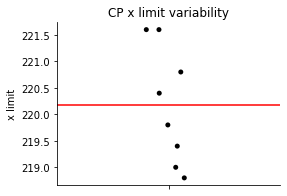

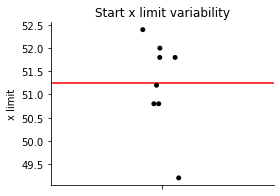

In [6]:
plot_compare_roi_limits_across_datasets(cp_rois,'CP x limit variability')
plot_compare_roi_limits_across_datasets(start_rois, 'Start x limit variability')

## Exploratory analysis

In [7]:
session_colors = sns.color_palette('Spectral', 12)
session_colors

[(0.7803152633602461, 0.182160707420223, 0.2968089196462899),
 (0.8996539792387543, 0.340715109573241, 0.2848904267589389),
 (0.9679354094579008, 0.5074202229911572, 0.2996539792387543),
 (0.9923875432525952, 0.6938869665513263, 0.3900807381776239),
 (0.9954632833525567, 0.8476739715494039, 0.519261822376009),
 (0.9985390234525182, 0.9547097270280661, 0.6730488273740869),
 (0.9634755863129566, 0.9853902345251826, 0.6920415224913495),
 (0.8656670511341794, 0.9460207612456749, 0.6034602076124567),
 (0.6841983852364477, 0.8722029988465976, 0.6403690888119954),
 (0.48489042675893923, 0.7940023068050751, 0.6458285274894272),
 (0.30403690888119955, 0.6537485582468281, 0.6913494809688582),
 (0.24006151480199922, 0.47635524798154555, 0.7141868512110727)]

In [8]:
phase_palette = [session_colors[0], session_colors[2], session_colors[4], 
                 session_colors[10]]

In [9]:
plot_context='talk'
sessions=ripples.session_code.unique()

#### Number of events per session

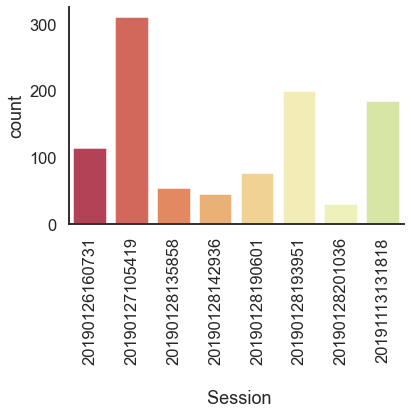

In [10]:
sns.set(context=plot_context, style='white')
plt.Figure(dpi=300, figsize=(12,3))
sns.countplot(
    x=ripples['session_code'],
    palette=session_colors
)
plt.xticks(rotation=90)
plt.xlabel('\n Session')
sns.despine()
plt.show()

#### Number of trials per session

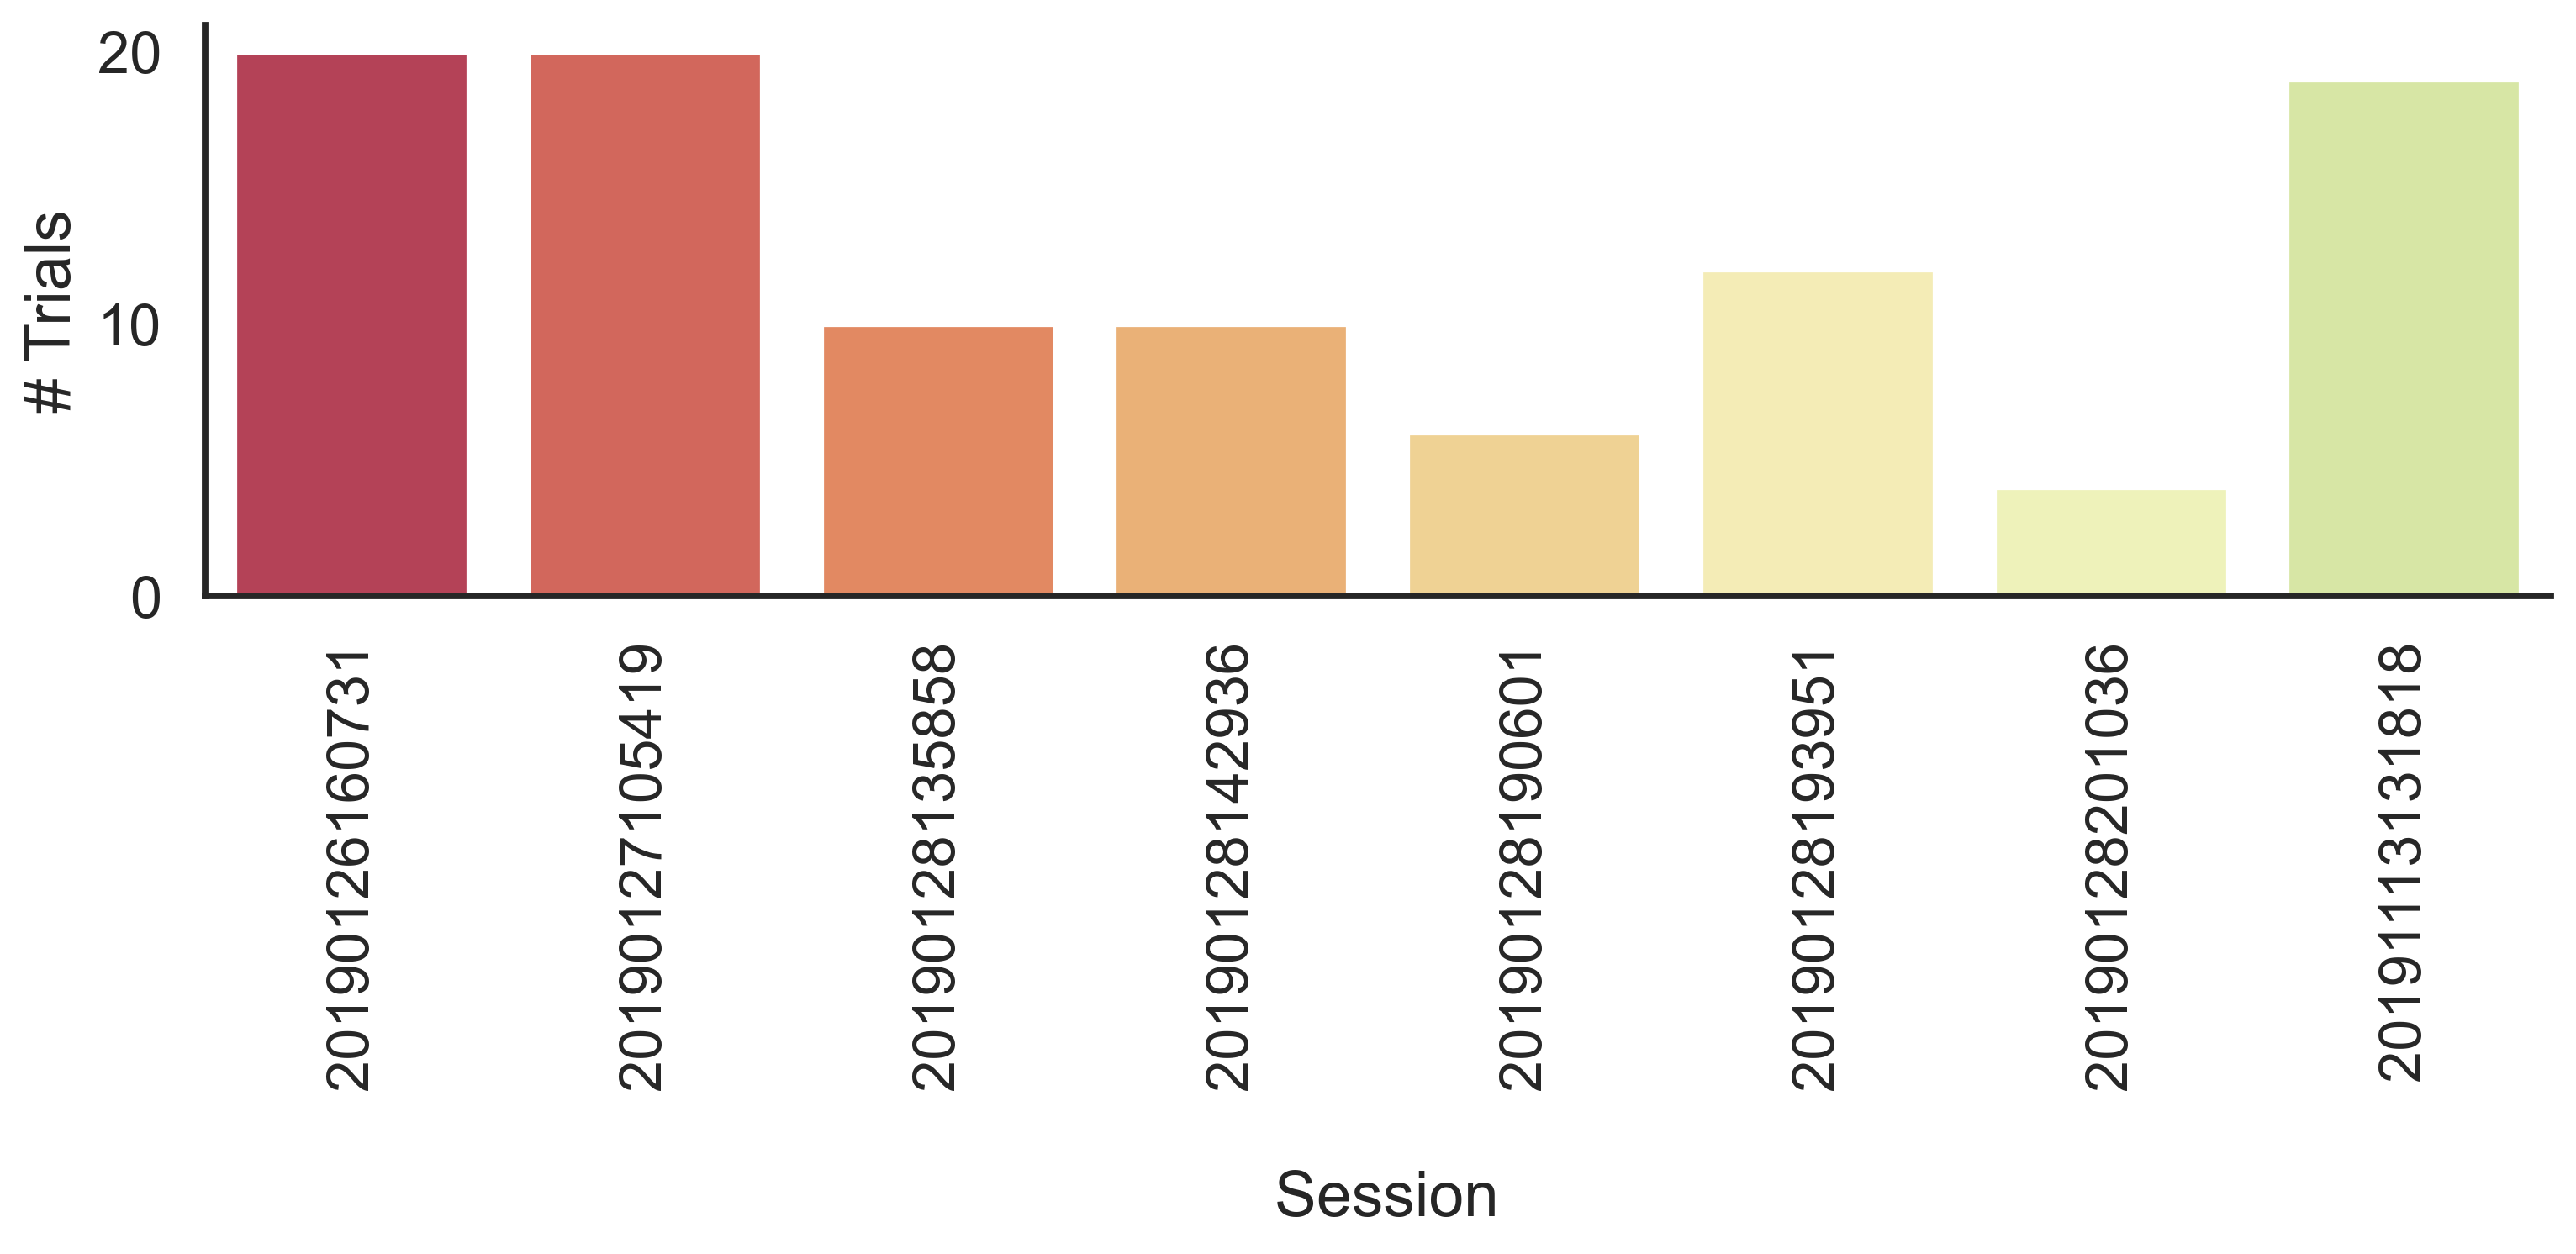

In [11]:
trials_per_session = position.groupby(['session_code']).trial_nr.nunique().reset_index()
sns.set(context=plot_context, style='white')
plt.figure(dpi=300, figsize=(12,3))
sns.barplot(
    data=trials_per_session,
    x='session_code',
    y='trial_nr',
    palette=session_colors
)
plt.xticks(rotation=90)
plt.xlabel('\n Session')
plt.ylabel('# Trials')
sns.despine()
plt.show()

## Location of ripple occurrence

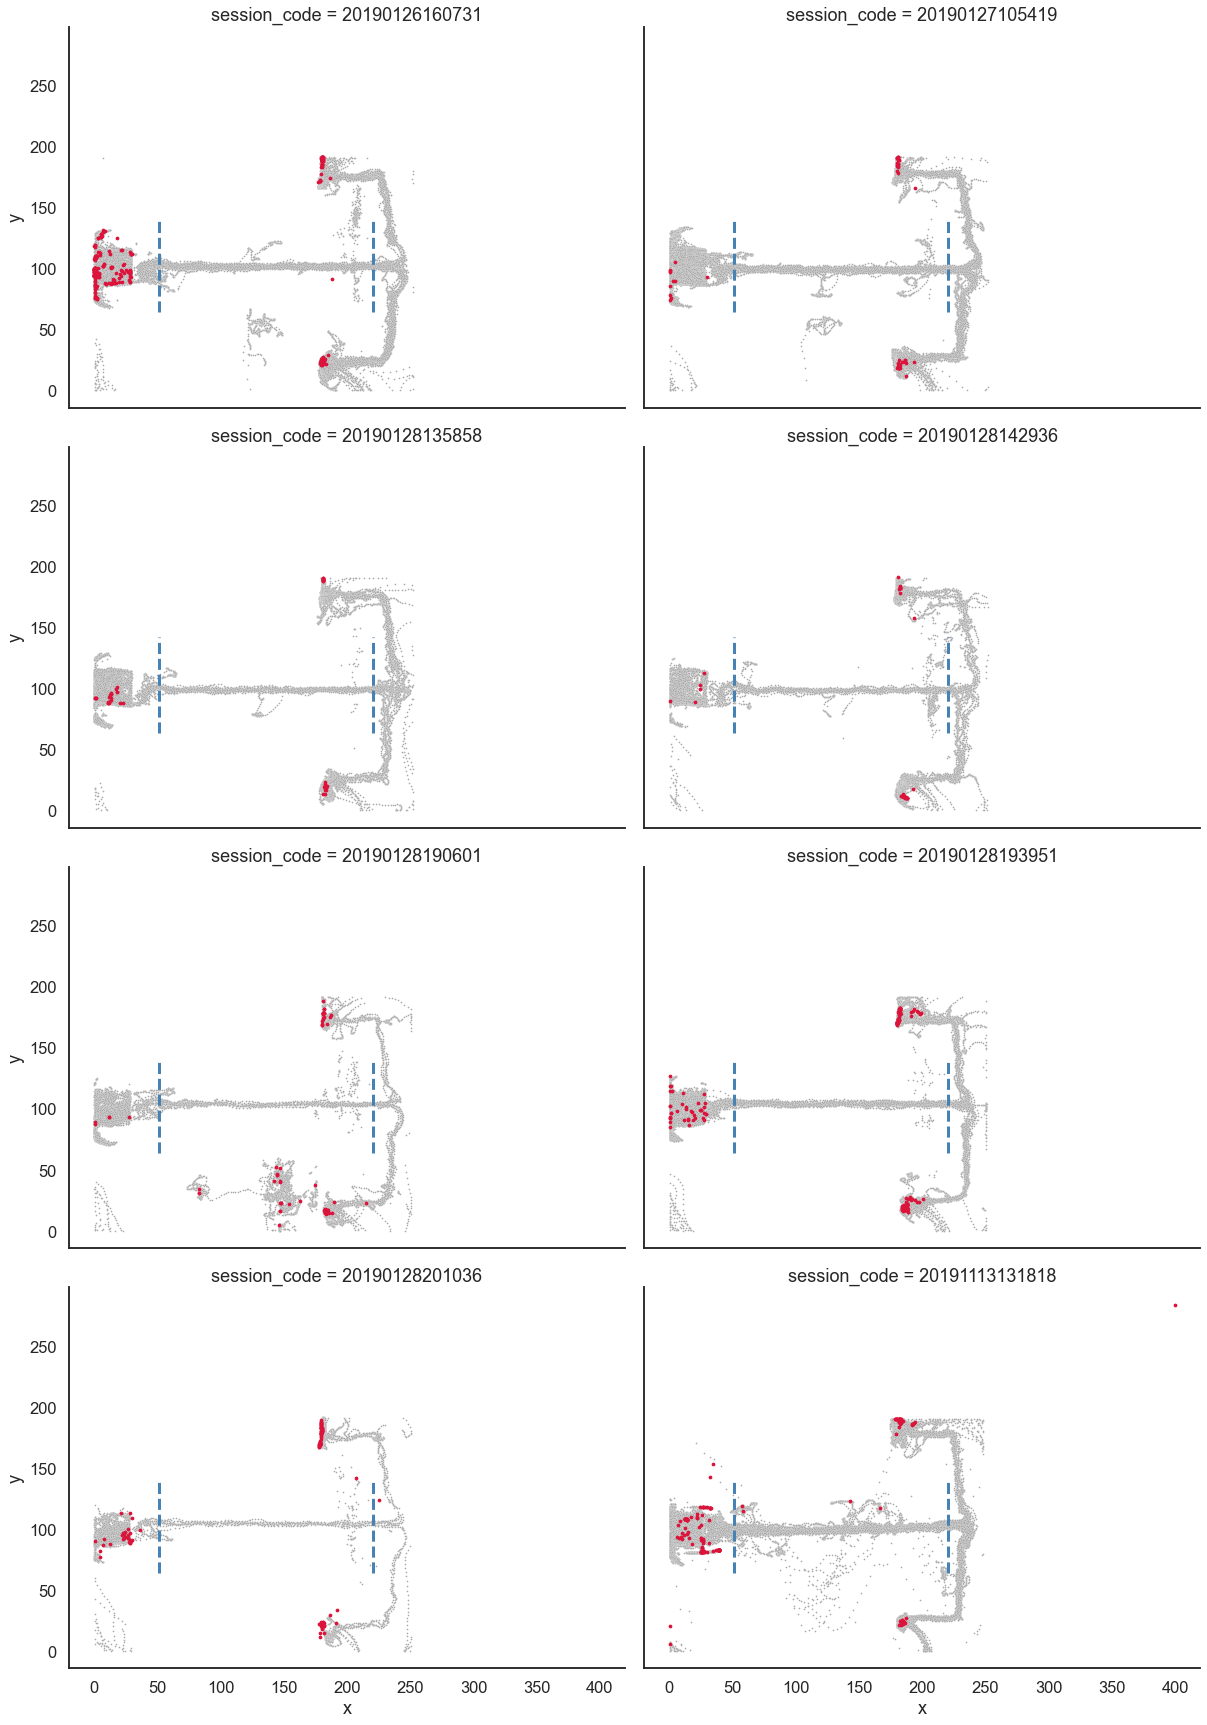

In [12]:
sns.set(style='white', context=plot_context)
# Plot position data
g=sns.relplot(
    kind ='scatter',
    data = position,
    col= 'session_code', col_wrap=2,
    x='x', 
    y='y', 
    color='darkgrey', 
    s=3, alpha=1,
    height=6, aspect=1.4
)
# Plot events
for ax, s in zip(g.axes.flatten(), sessions):
    ax.scatter(
        ripples.loc[ripples.session_code == s, 'x_ripple'],
        ripples.loc[ripples.session_code == s, 'y_ripple'], 
        color='crimson', s=5)
    
    # Plot limits (using the mean)
    ax.axvline(np.mean(start_rois.x), 0.25, 0.5, color='steelblue', linewidth=3, linestyle='dashed')
    ax.axvline(np.mean(cp_rois.x), 0.25, 0.5, color='steelblue', linewidth=3, linestyle='dashed') 
    
g.despine()

Session 20190128190601 from Magalhães has position data associated with the box that was not cleaned out during the ripple clean up. After checking the video, I confirmed that this position data - and corresponding ripples - are not trial bound. For this reason, I will remove them from the pool of SWR events to analyse. We can also find one SWR detected on session 20191113131818 that is clearly outside of the maze - probably due to a loss of position data. I will remove it too.

In [13]:
# Boolean mask to drop events from box in 20190128
to_drop_mask1 = (ripples['session_code']==20190128190601)&\
        (ripples['run_type']=='T') & (ripples['x_ripple'].between(70,170)) &\
        ripples['y_ripple'].between(0,60)

# Boolean mask to drop event from 20191131
to_drop_mask2 = ripples['x_ripple']>300

In [14]:
ripples = ripples[~(to_drop_mask1) & ~(to_drop_mask2)]

#### Number of events in total after removal

In [15]:
len(ripples)

1000

#### Collapse previous plot into a single one, color-code by session

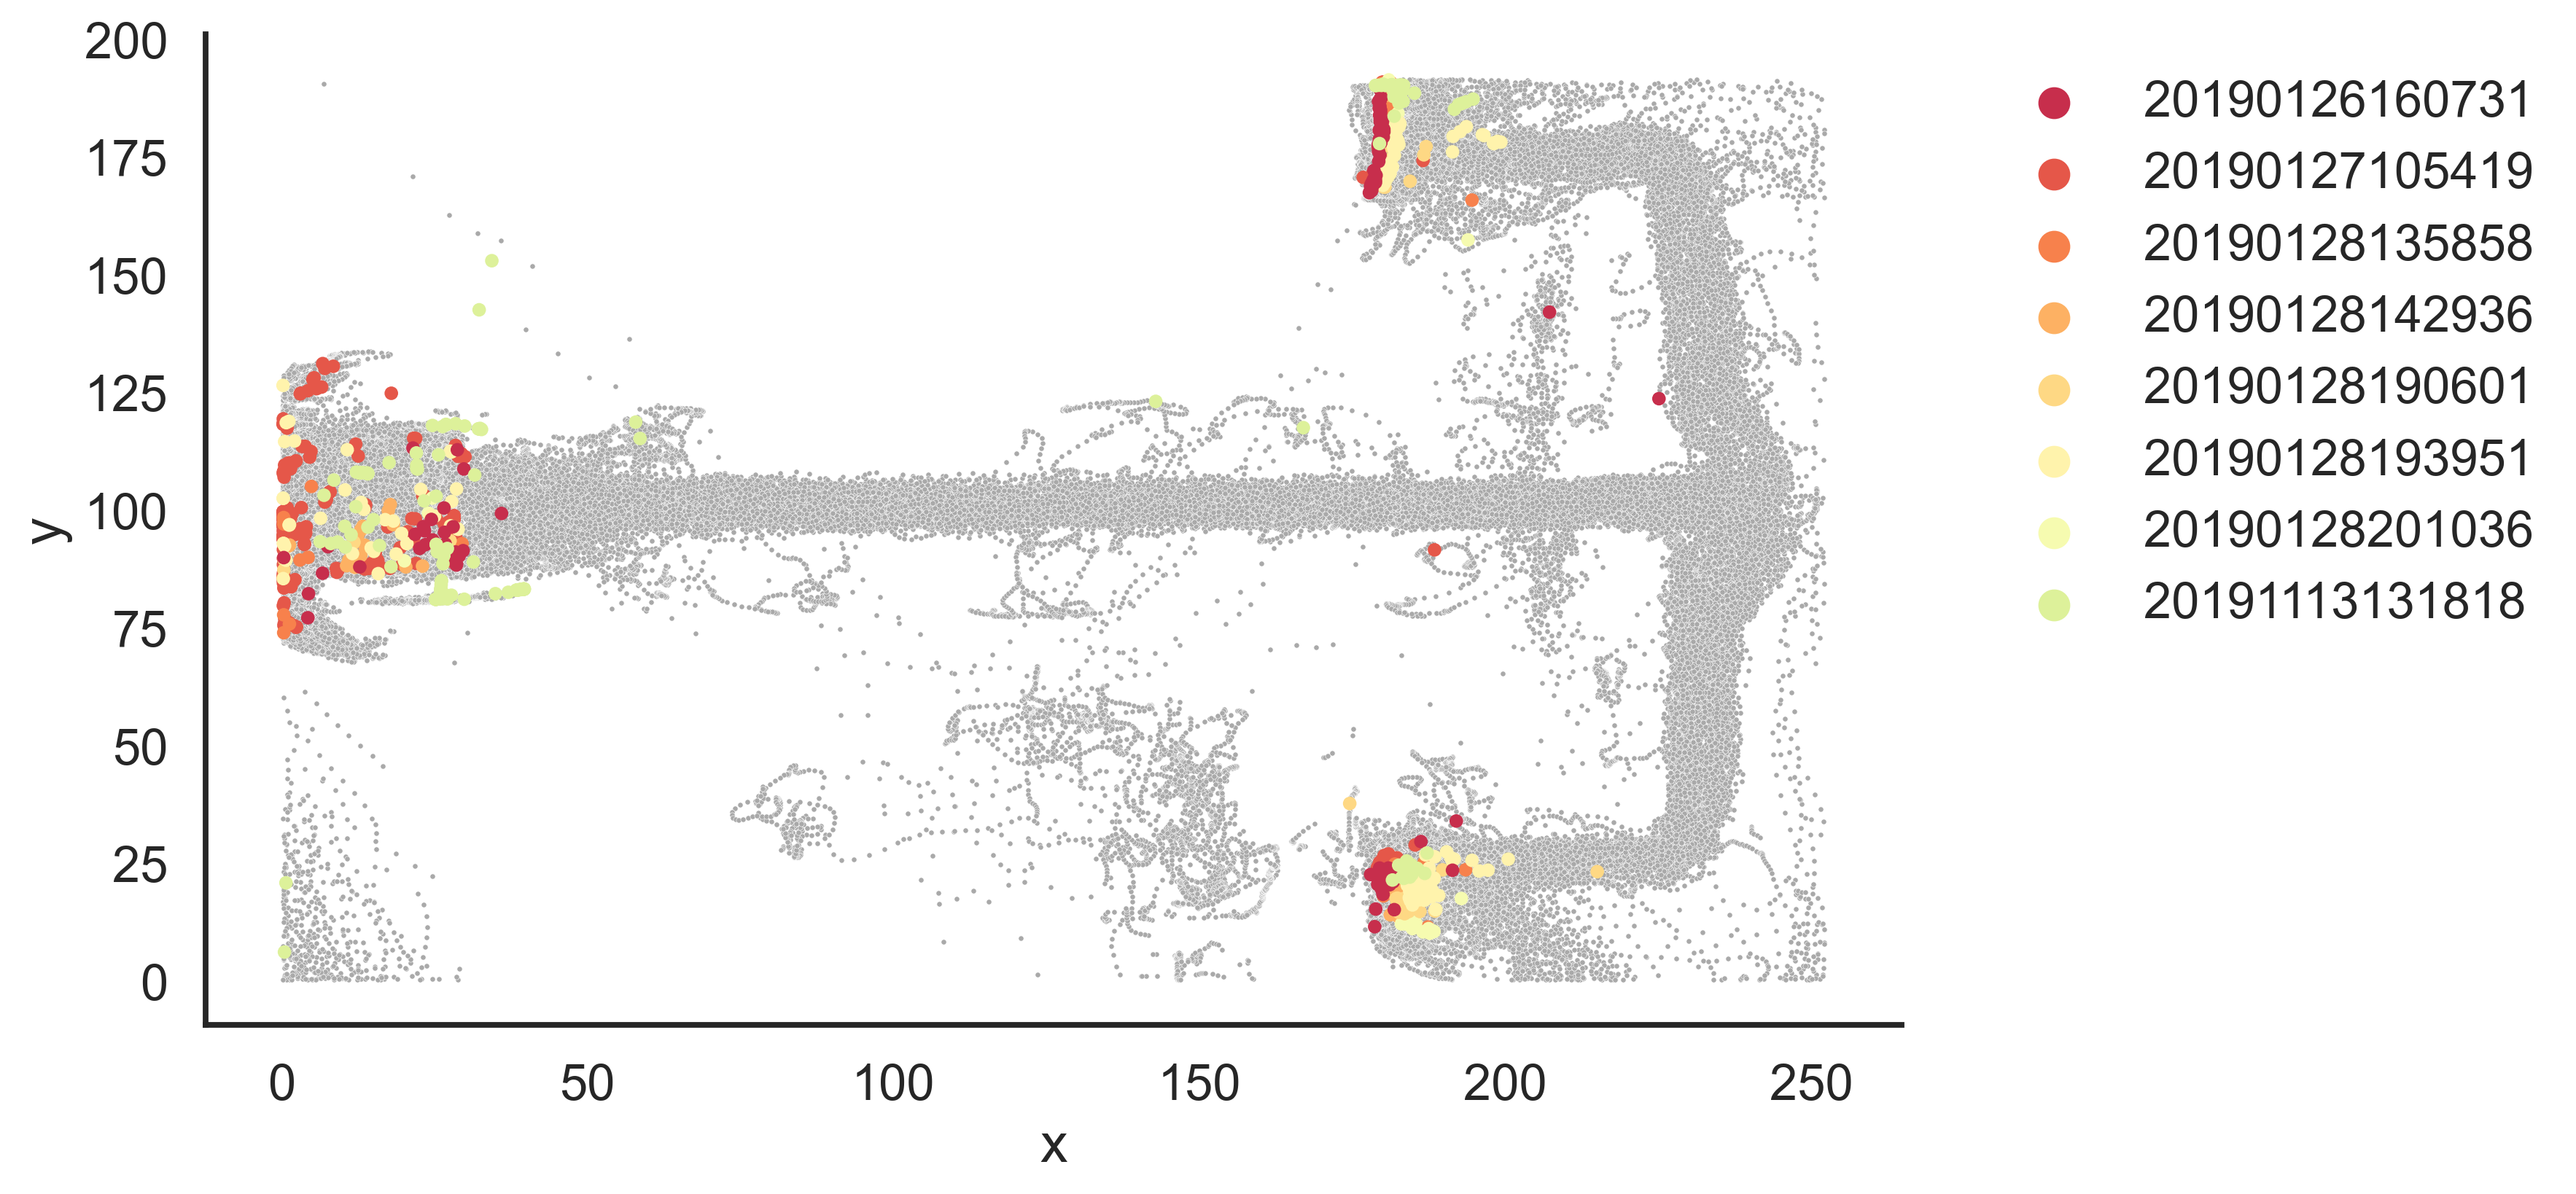

In [16]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(10,6))
# Plot position data
g=sns.scatterplot(
    data = position,
    x='x', 
    y='y', 
    color='darkgrey', 
    s=3, alpha=1)

# Plot events
sns.scatterplot(
    data = ripples,
    x = 'x_ripple',
    y = 'y_ripple',
    hue='session_code',
    palette=session_colors[0:len(sessions)],
    linewidth=0, 
    s=20)

plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)
sns.despine()

#### Is the rate of occurrence different across trials?
Rate of SWR occurrence = Number of events in a given trial / trial duration. A trial includes ITI before trial, Sample, Delay and Test.

In [17]:
# Calculate trial duration using position data
trial_duration = position.groupby(['session_code','trial_nr']).apply(lambda x:
                                                     x['timestamp'].iloc[-1] - x['timestamp'].iloc[0])
# Calculate the SWR events / sec
rate_across_trials = ripples.groupby(['session_code','trial_nr']).apply(
    lambda x, y: len(x)/y.loc[int(x.session_code.iloc[0]), x.trial_nr.iloc[0]], trial_duration)

rate_across_trials=rate_across_trials.reset_index().rename(columns={0:'rate'})

In [18]:
trial_duration.describe()

count    101.000000
mean     121.394560
std       33.466836
min       85.253709
25%      106.849229
50%      112.931635
75%      126.425062
max      322.664602
dtype: float64

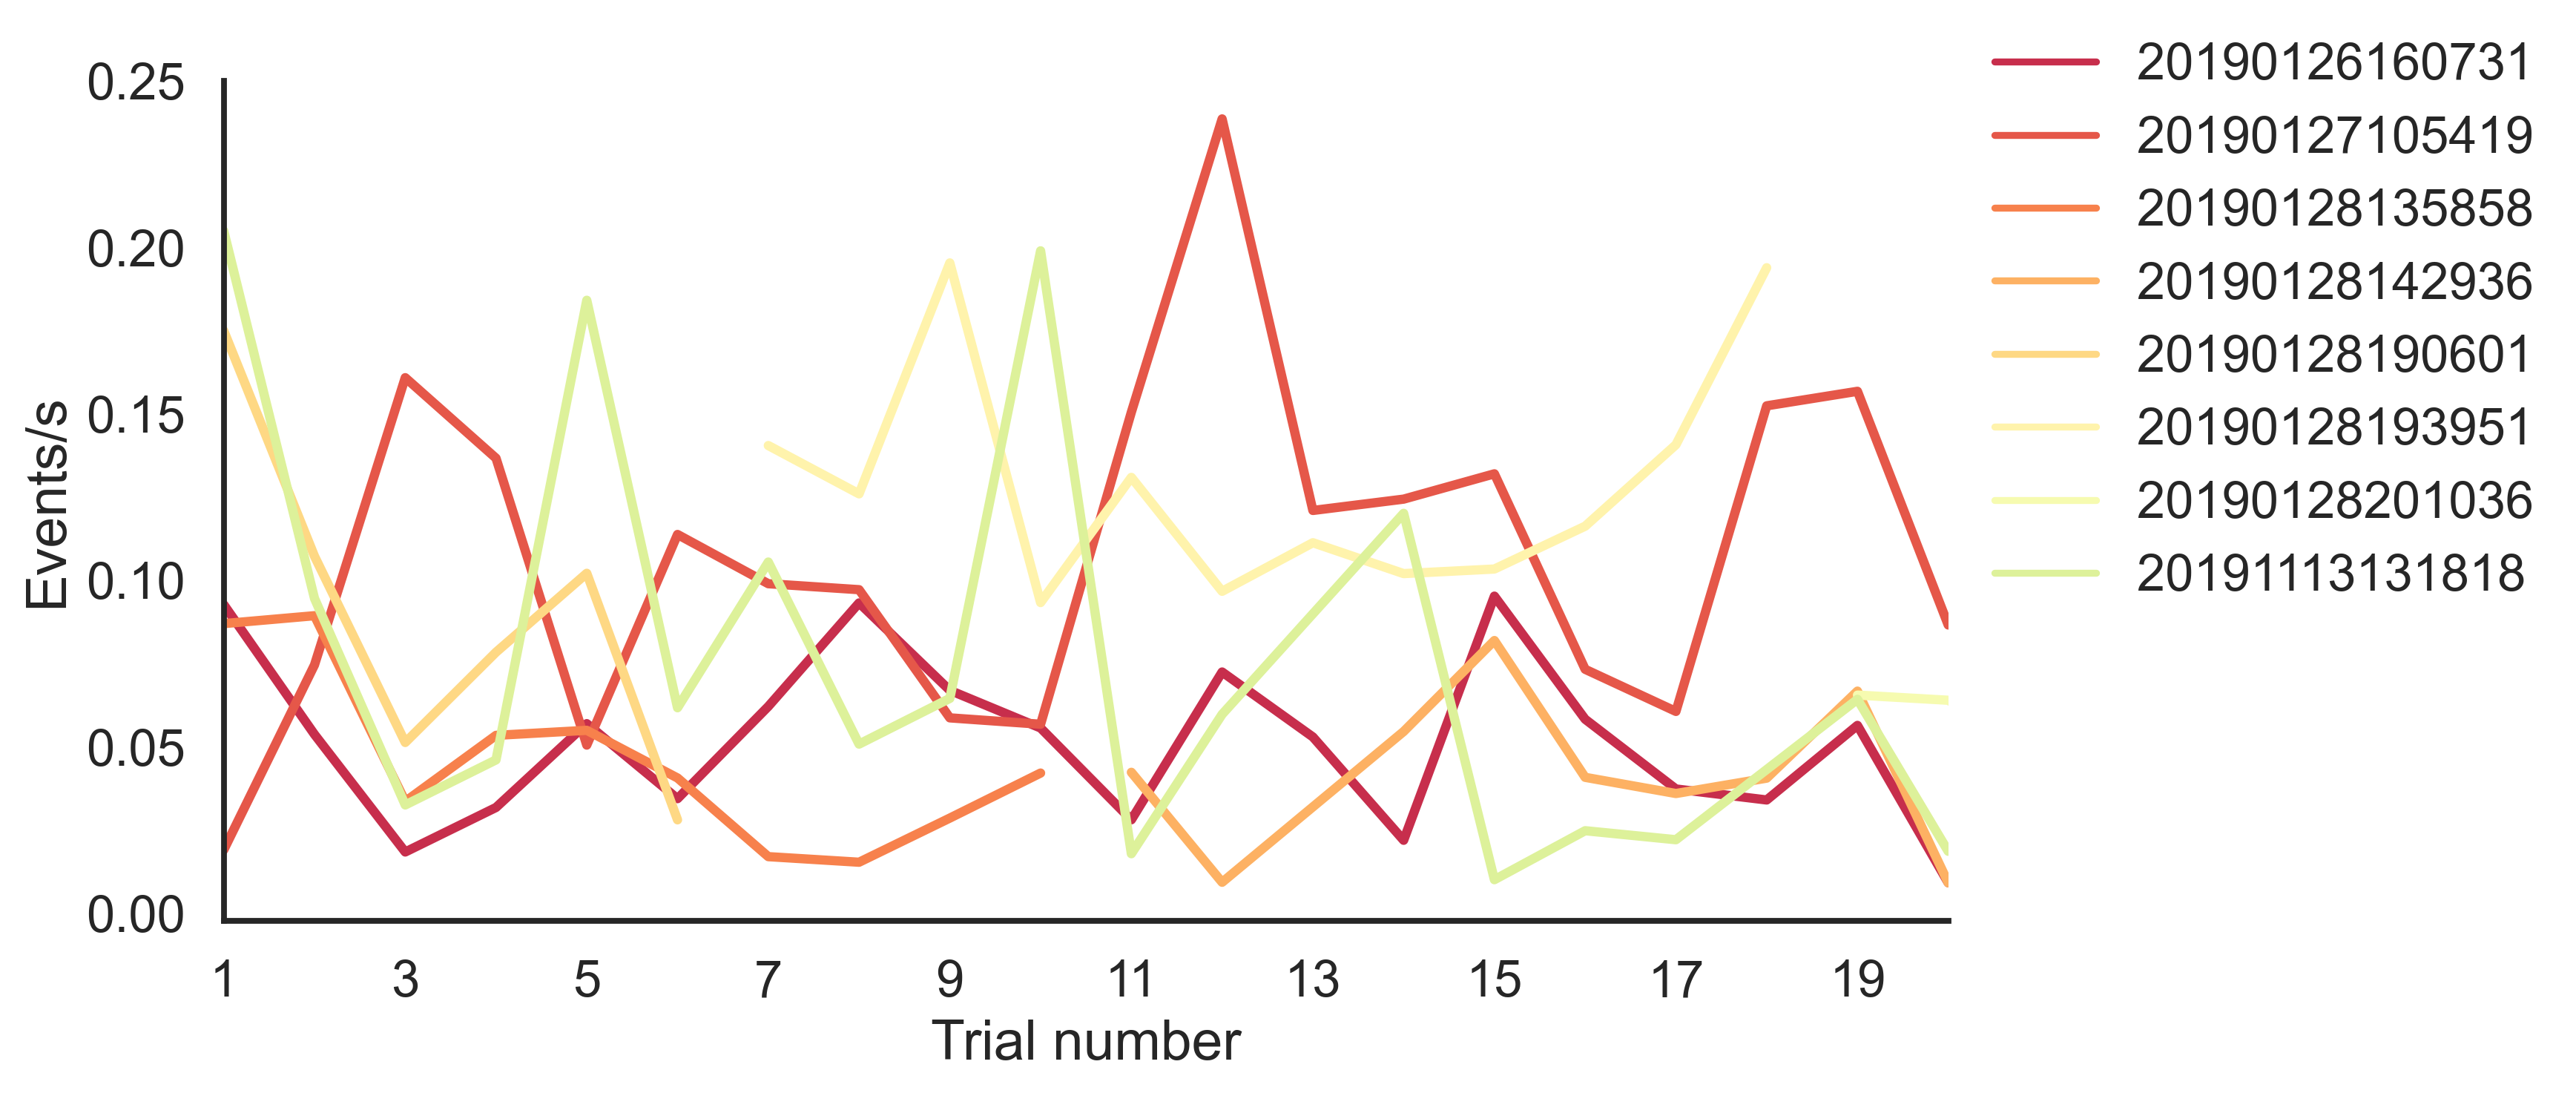

In [19]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(10,5), dpi=300)
sns.lineplot(data=rate_across_trials, y='rate', x='trial_nr', hue='session_code',
            palette=session_colors[0:len(sessions)], linewidth=3)
plt.xticks(range(1,21,2))
plt.xlabel('Trial number')
plt.ylabel('Events/s')
plt.xlim([1,20])
plt.legend(bbox_to_anchor=(1,1.1), frameon=False)
sns.despine()

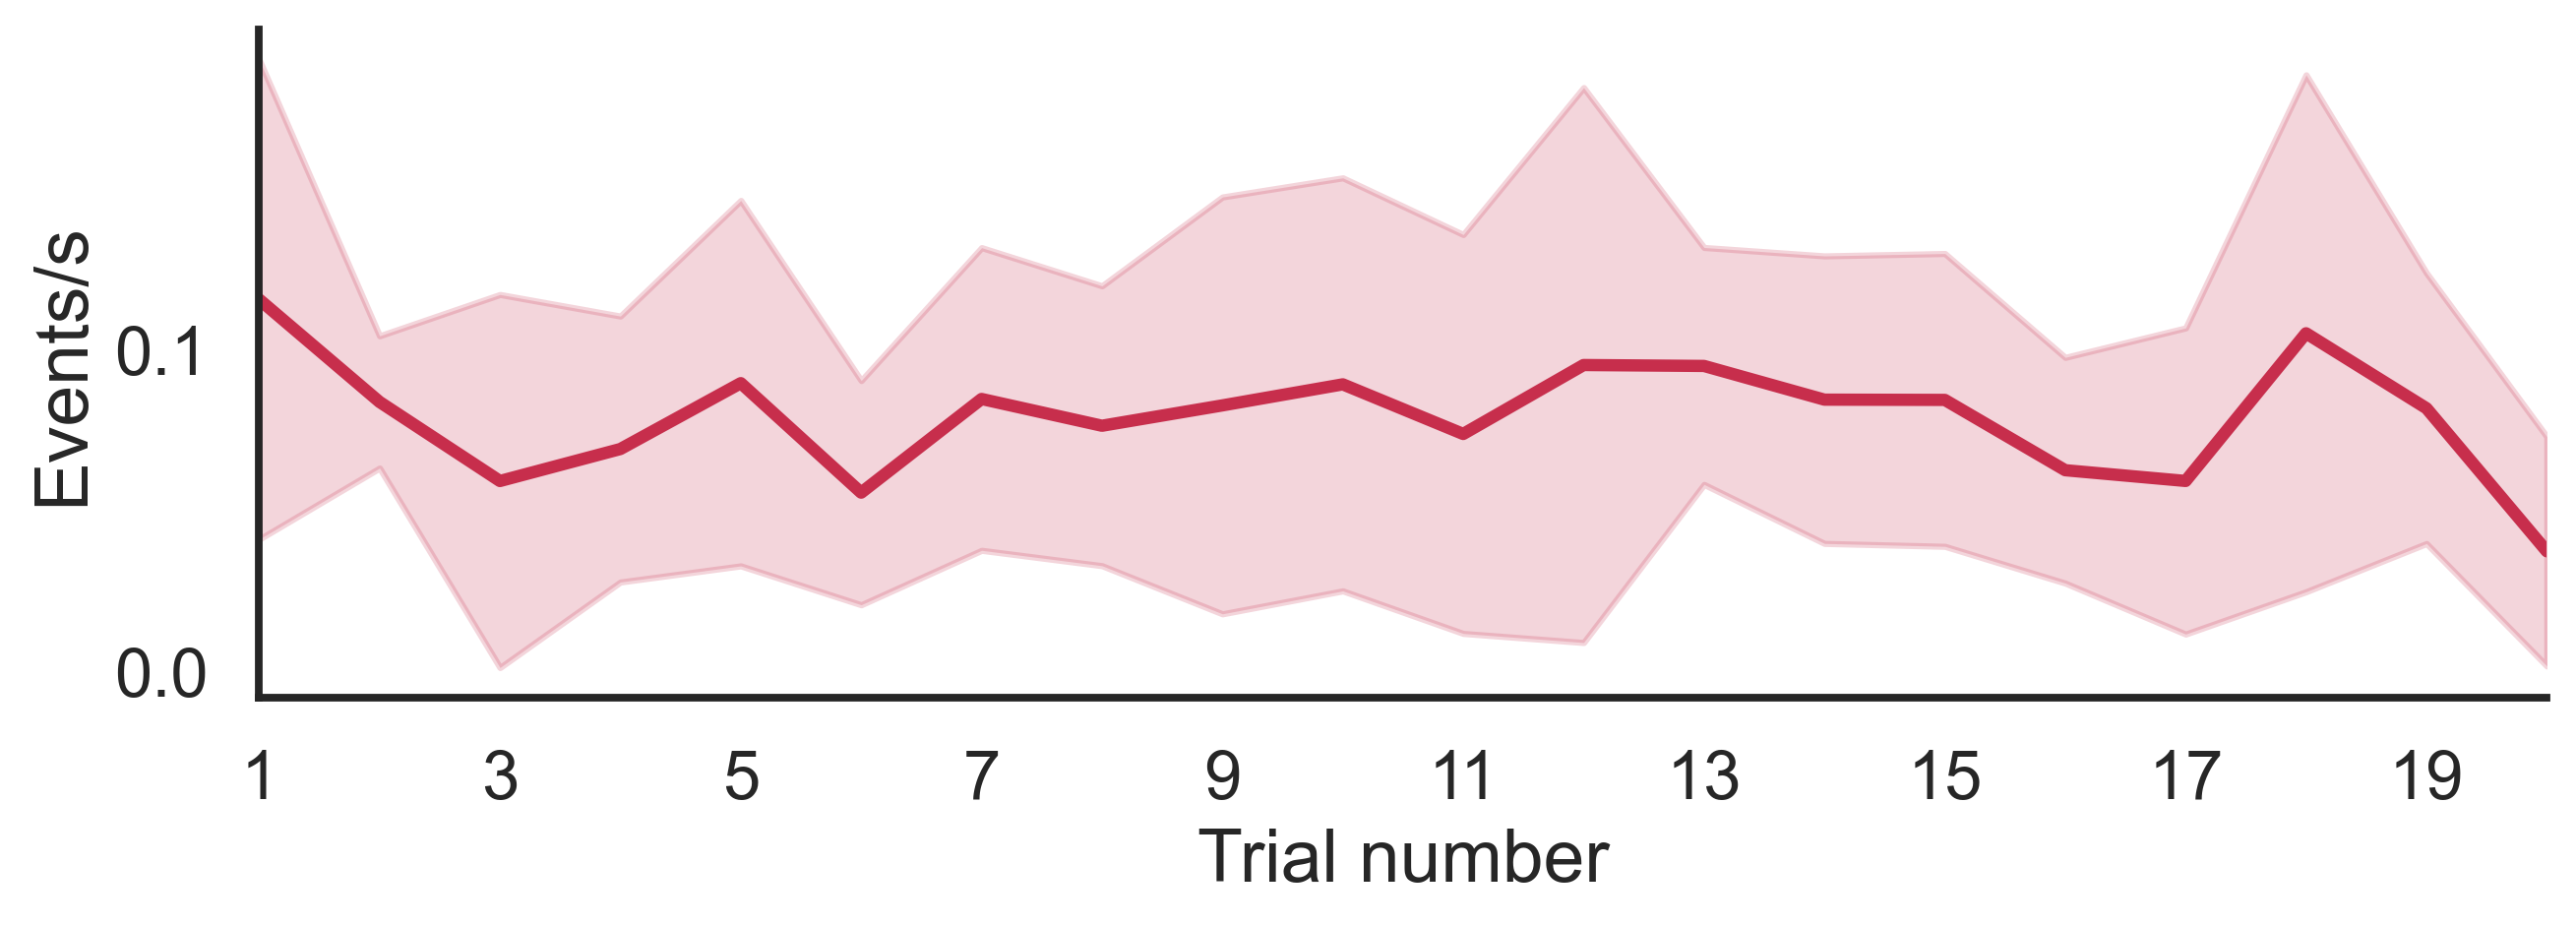

In [20]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(10,3), dpi=300)

sns.lineplot(
    data=rate_across_trials, 
    y='rate', x='trial_nr', 
    linewidth=3, ci='sd', color=session_colors[0])

plt.xticks(range(1,21,2))
plt.xlabel('Trial number')
plt.ylabel('Events/s')
plt.xlim([1,20])
sns.despine()

### Trial rate variabiity within and across sessions

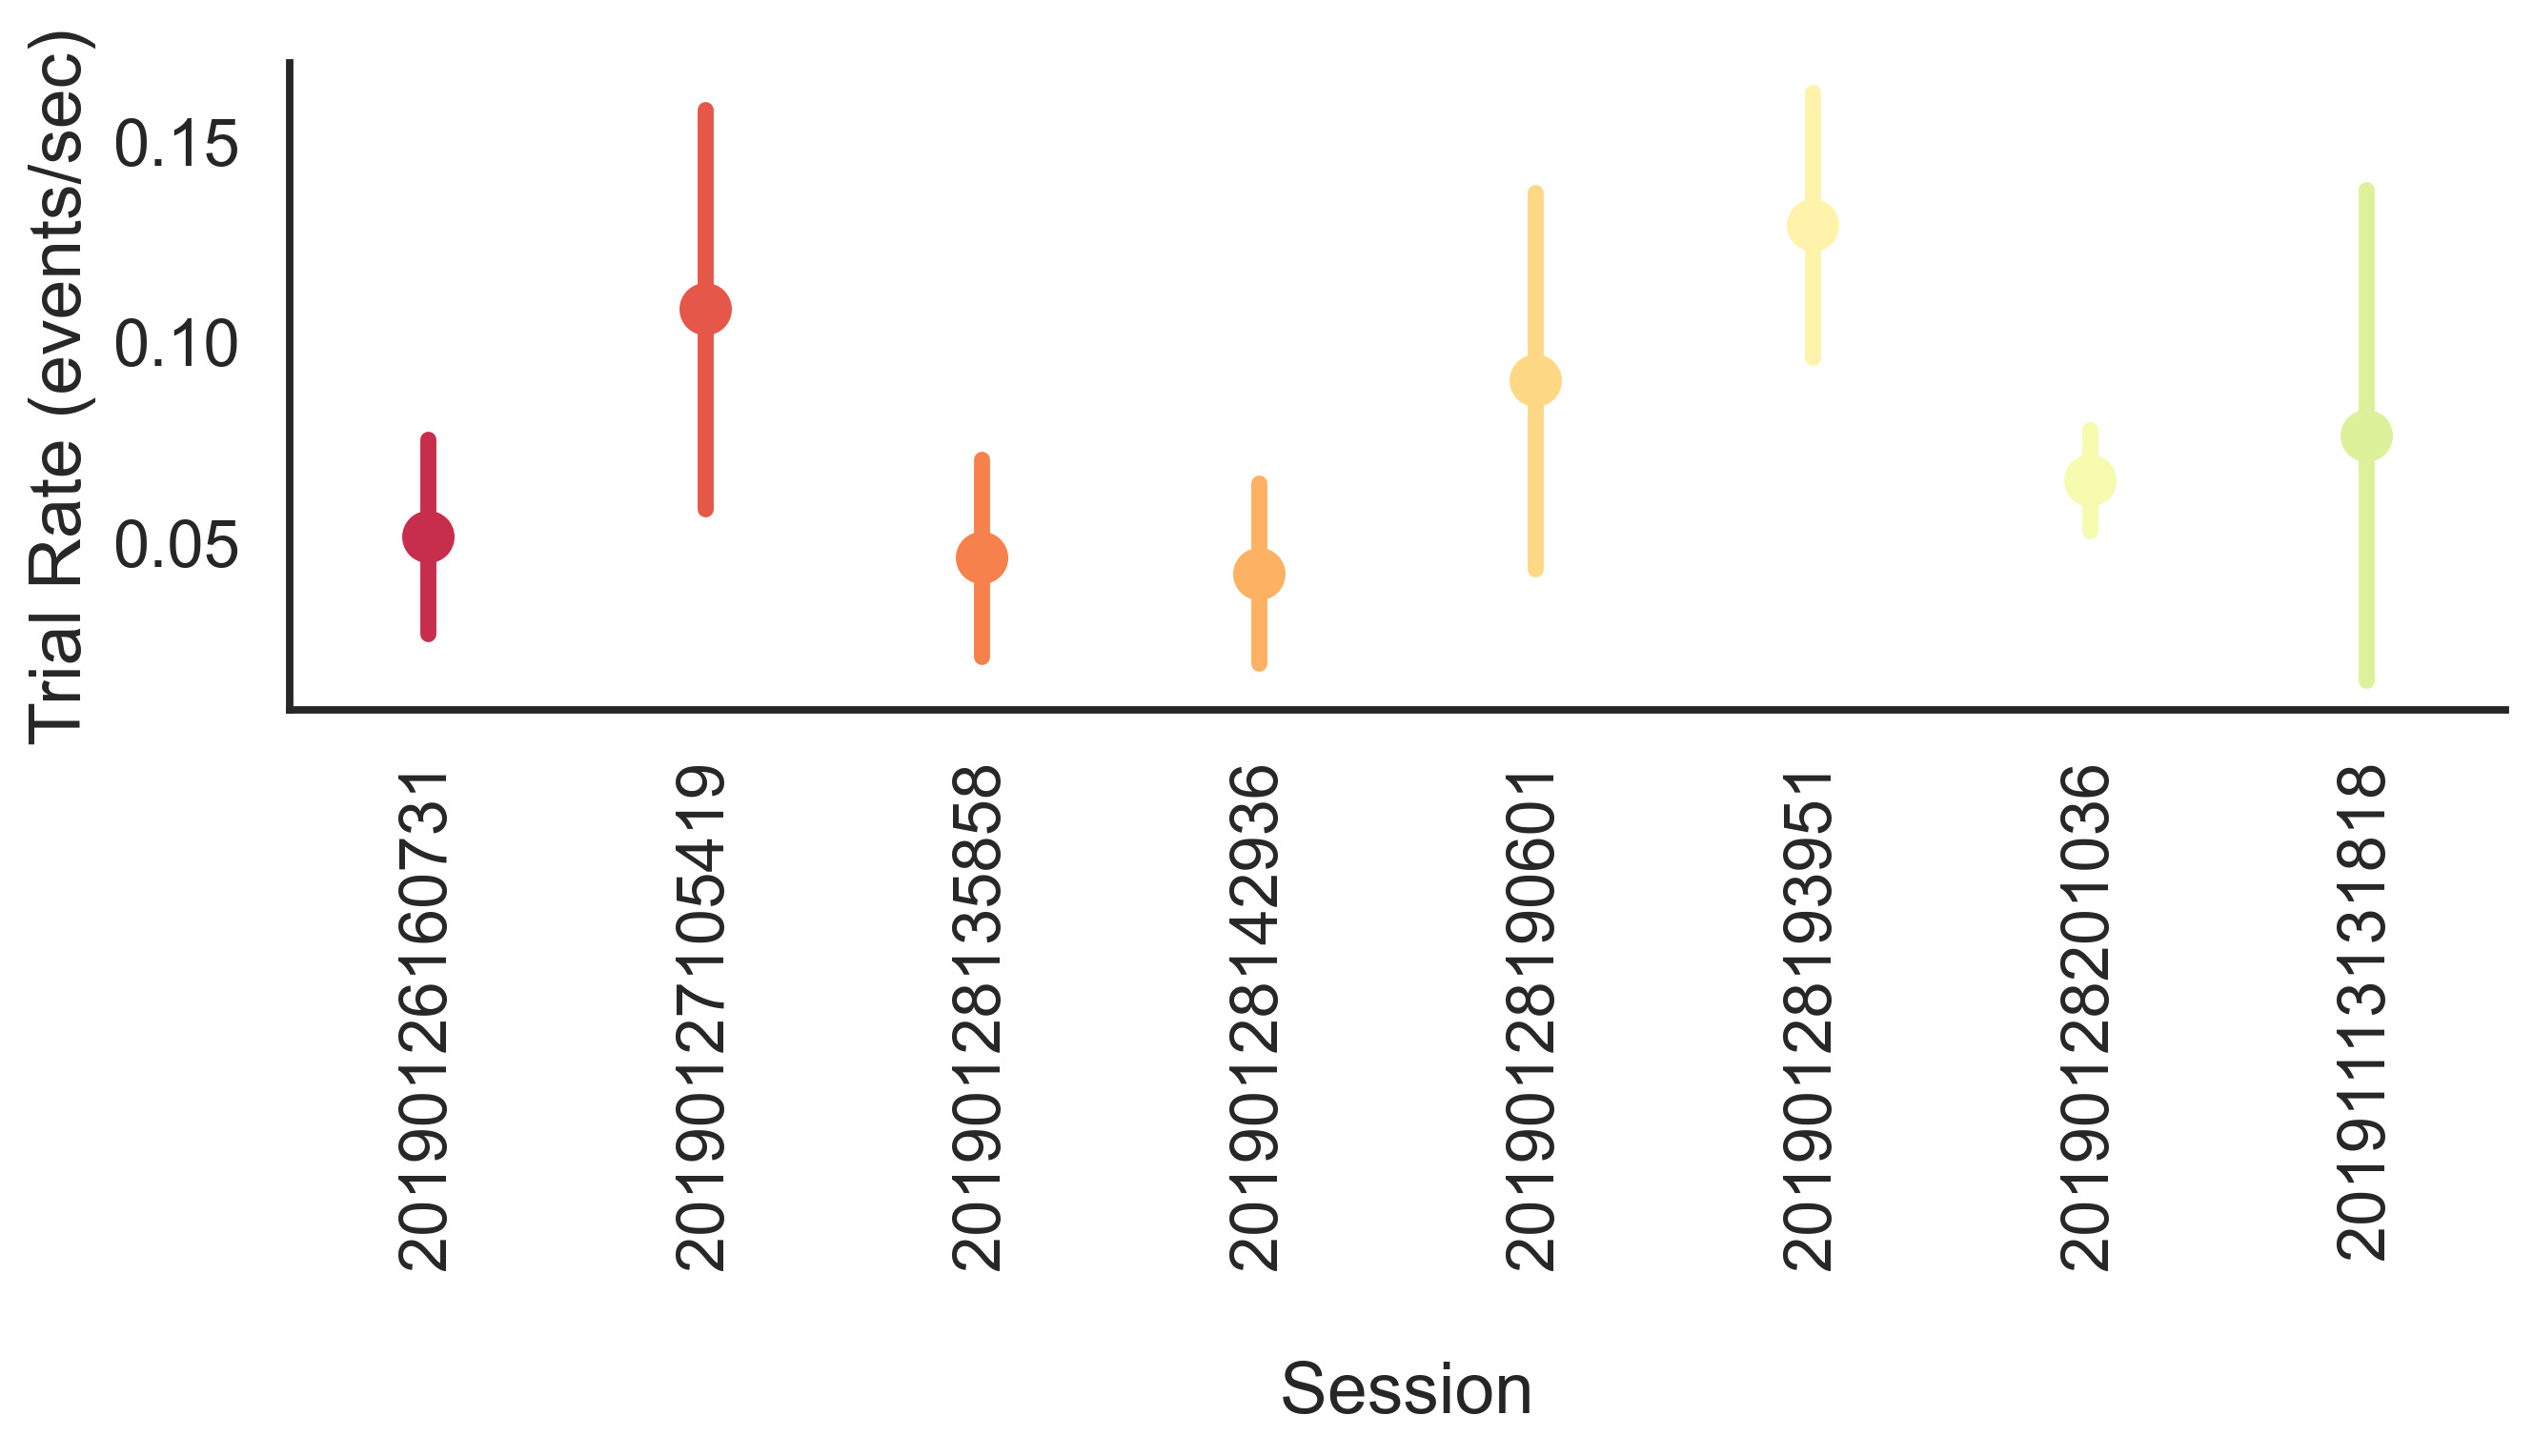

In [21]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(10,3), dpi=300)

g=sns.pointplot(
data=rate_across_trials,
x='session_code',
y='rate',
hue='session_code',
palette=session_colors,
ci='sd')

plt.xticks(rotation=90)
plt.xlabel('\n Session')
plt.ylabel('Trial Rate (events/sec)')
g.legend_.remove()
sns.despine()

#### What is the duration of the events?
Just to check the overall distribution of the events.

In [22]:
# Calculate the duration of the events
ripples['duration_sec']=ripples['end_time']-ripples['start_time']
ripples['duration_ms']=ripples['duration_sec']*1000

<Figure size 1800x1200 with 0 Axes>

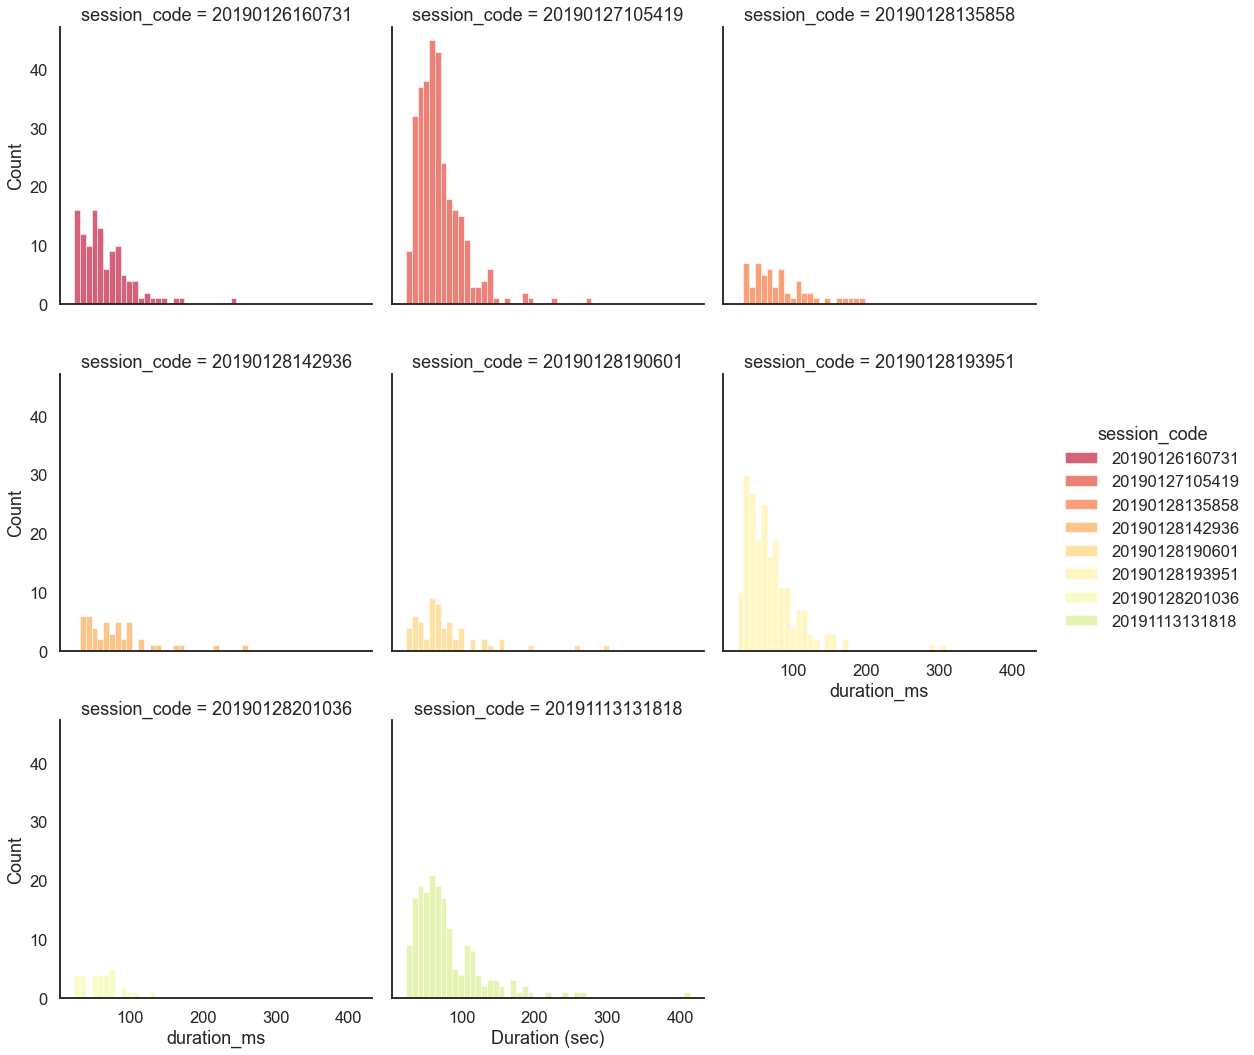

In [23]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300)

g=sns.displot(
    kind='hist', 
    col='session_code',col_wrap=3,
    data=ripples, x='duration_ms', hue='session_code', 
    palette=session_colors[0:len(sessions)]
)

plt.xlabel('Duration (sec)')
sns.despine()

In [24]:
ripples.duration_ms.describe()

count    1000.000000
mean       72.159000
std        40.136002
min        23.500000
25%        46.000000
50%        63.000000
75%        86.000000
max       413.000000
Name: duration_ms, dtype: float64

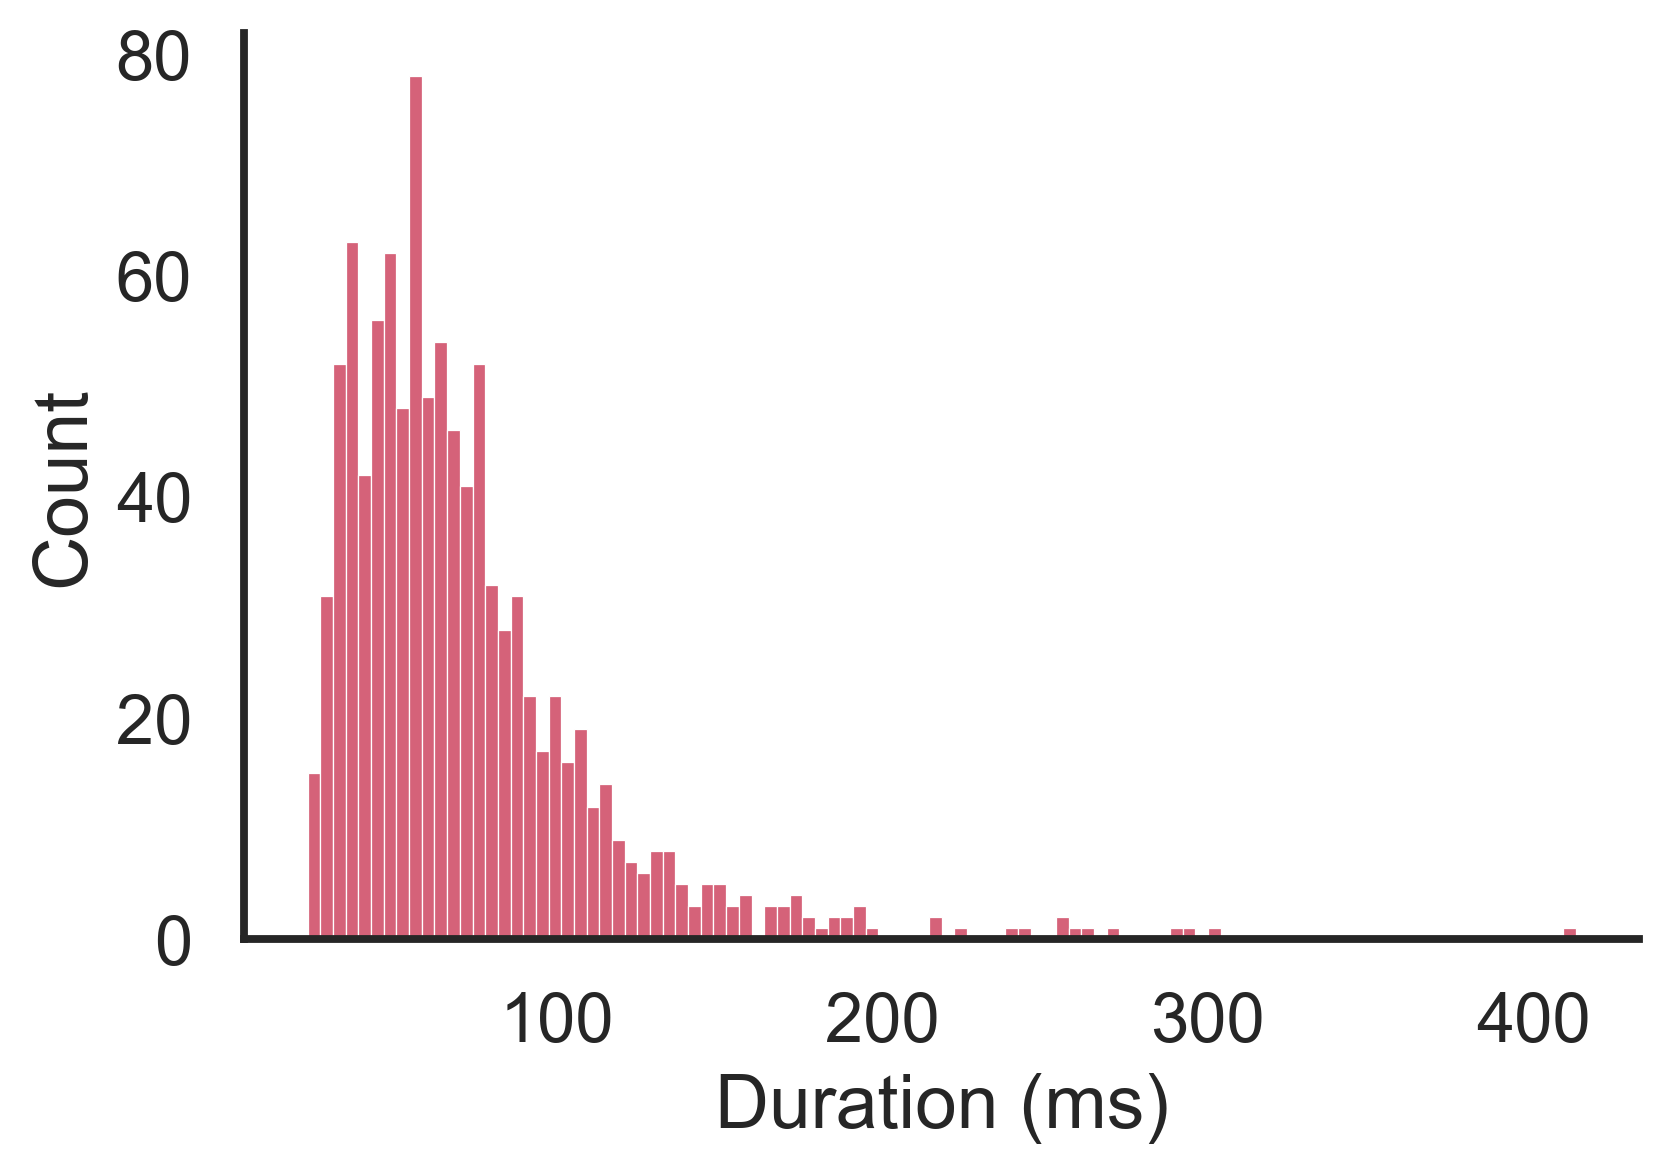

In [25]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300)
g=sns.histplot( 
    data=ripples, 
    x='duration_ms',
    color=session_colors[0],
    bins=100
)

plt.xlabel('Duration (ms)')
sns.despine()

## Explore by task phase and trial outcome

- Rate of occurrence (Hz) by task phase and trial outcome - per trial
- Distribution of ripple duration (ms) by task phase and trial outcome.

In [26]:
def divide_by_task_phase(df, start_rois, cp_rois, x, y):
    '''
    Each ripple will be classified as belonging to each task phase
    using the ROIs collected before.
    '''
    
    session_code=df.session_code
    session_start=start_rois.loc[start_rois['session_code']==session_code, 'x'].iloc[0]
    session_cp = cp_rois.loc[cp_rois['session_code']==session_code, 'x'].iloc[0]
    
    if df.run_type=='S' and df[x] <= session_start:
        return 'ITI'
    elif df.run_type=='S' and df[x]>session_start:
        return 'Sample'
    elif  df.run_type=='T' and  df[x]<=session_start:
        return 'Delay'
    elif df.run_type=='T' and df[x] > session_start and df[x] <=session_cp and \
        df[y]>= 60 and df[y] <=130:
        return 'Test (Pre-choice)'
    else:
        return 'Test (Past-choice)'

#### Classify by task phase

In [27]:
# Classify ripples by task phase
ripples['phase'] = ripples.apply(divide_by_task_phase, 
                                 args=(start_rois, cp_rois, 'x_ripple', 'y_ripple'), axis=1)

#Similar to the above but for each single position data point
position['phase'] = position.apply(divide_by_task_phase, 
                                 args=(start_rois, cp_rois, 'x', 'y'), axis=1)

In [33]:
# Save ripples dataframe
ripples.to_csv(os.path.join(main_path, 'ripples_classified.csv'), index=False)

#### Confirm classification

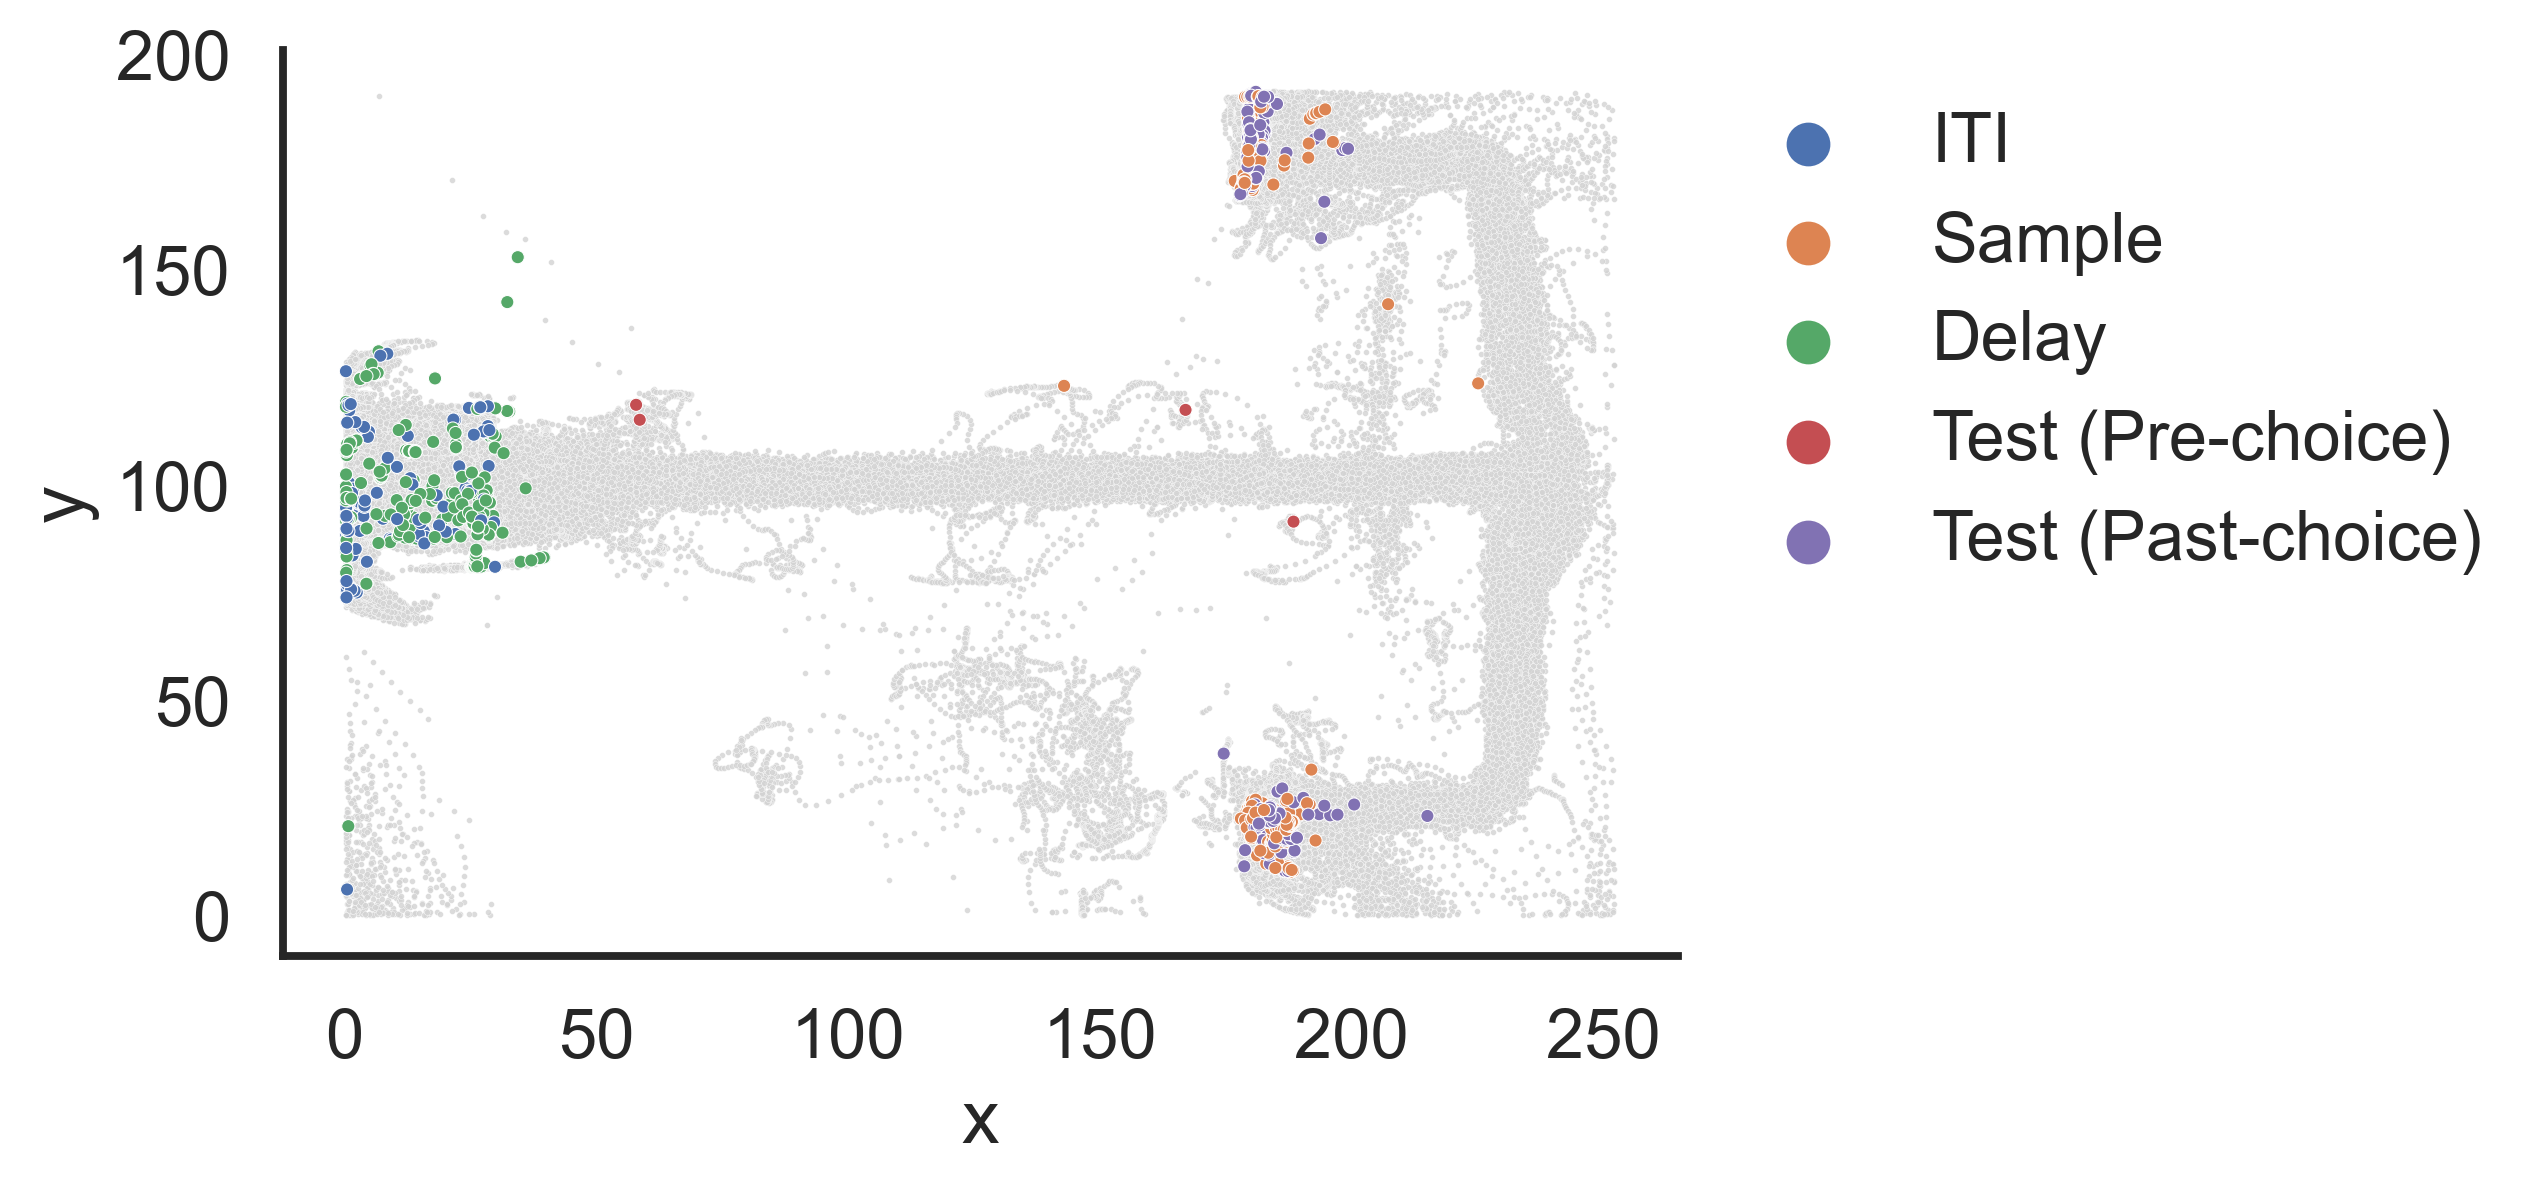

In [32]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(6,4))
order = ['ITI', 'Sample', 'Delay', 'Test (Pre-choice)', 'Test (Past-choice)']

g = sns.scatterplot(
    data = position,
    x='x', y='y',
    color='lightgray', s=2, alpha=.8
)

sns.scatterplot(
    data = ripples,
    x='x_ripple', y='y_ripple', hue='phase',
    s=10,  alpha=1,
    hue_order=order)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

There are so little Test(Pre-choice) events that I will combine both pre-choice and post-choice Test events

In [33]:
ripples.loc[(ripples['phase']=='Test (Pre-choice)')|(ripples['phase']=='Test (Past-choice)'), 
            'phase']='Test'
position.loc[(position['phase']=='Test (Pre-choice)')|(position['phase']=='Test (Past-choice)'), 
             'phase']='Test'

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


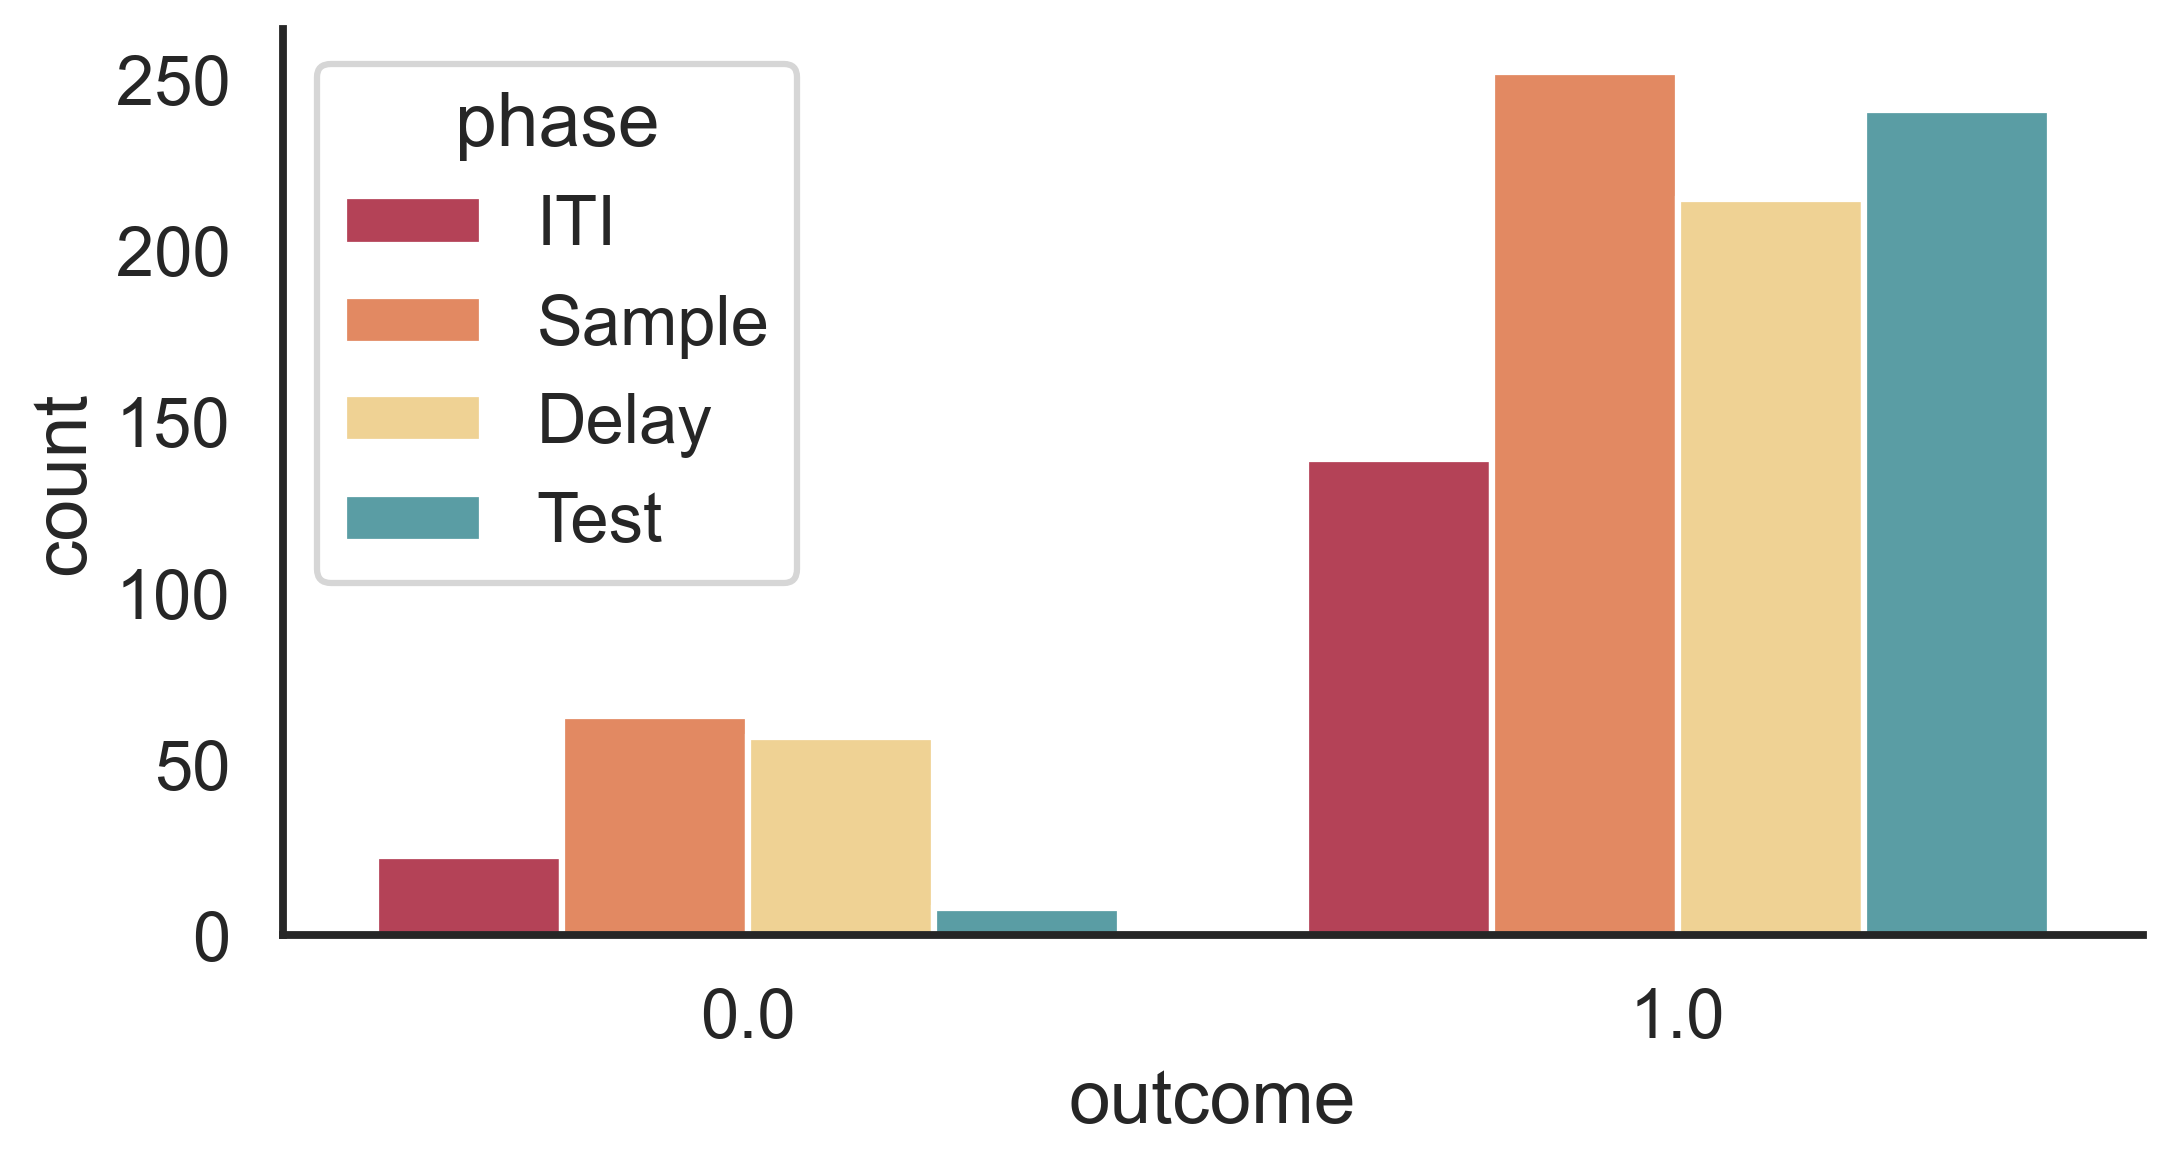

In [34]:
order = ['ITI', 'Sample', 'Delay', 'Test']
sns.set(style='white', context=plot_context)
plt.figure(figsize=(8,4), dpi=300)

g= sns.countplot(data=ripples,  x='outcome', hue='phase',
            palette=phase_palette, hue_order=order)

#.set_xlabel('Trial outcome')
#g.set_ylabel('Count')
#g.set_xticklabels(['Incorrect', 'Correct'])
#plt.legend(bbox_to_anchor=(1.1,1), frameon=False)
sns.despine()

In [35]:
# stacked bar to 100% per task phase

### Event rate by task phase 
<br>
Normalized to the total amount of time the rat was within that task phase, per trial. 

Sum( # events in task phase) / Sum ( # time spent in task phase), per trial

In [36]:
# Calculate time spent in each task phase and trial (denominator)
phase_durations = position.groupby(['session_code', 'trial_nr', 'phase'])['timestamp'].agg(['min', 'max'])
phase_durations['duration_s'] = phase_durations['max']-phase_durations['min']
# Calculate ripples per trial
ripple_count=ripples.groupby(['session_code', 'trial_nr','phase'])['start_time'].count().reset_index().rename(
    {'start_time':'ripples'}, axis=1)

In [37]:
# Combine both datasets (count of events per dataset and task phase)
rate_by_phase = pd.merge(
    phase_durations, 
    ripple_count,
    how='left', 
    on=['session_code', 'trial_nr','phase']
).fillna(0)

In [38]:
# Calculate the rate per task phase and dataset
rate_by_phase['rate']=rate_by_phase['ripples']/rate_by_phase['duration_s']

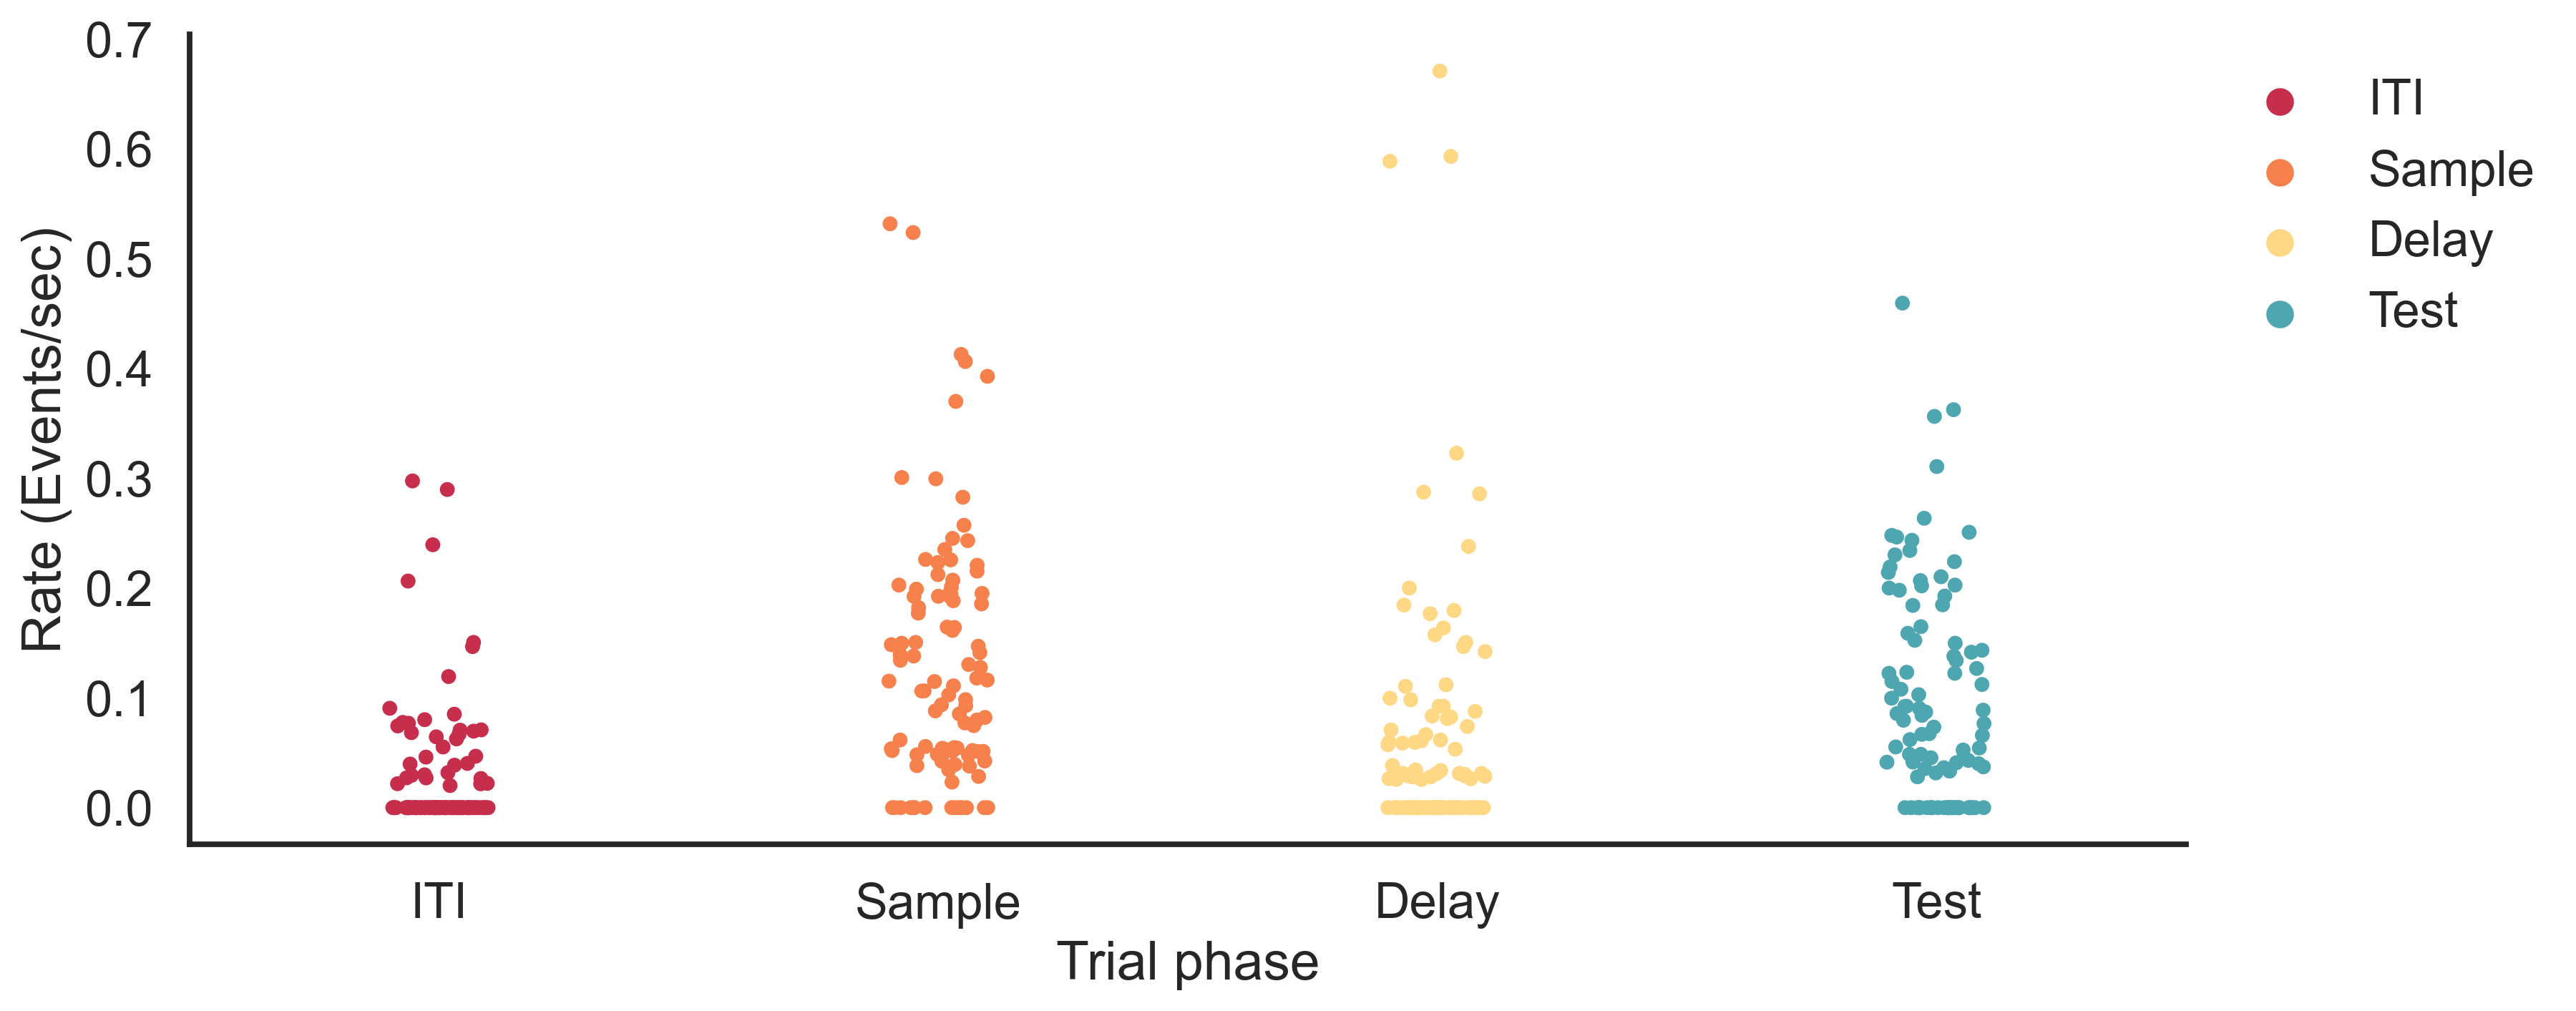

In [39]:
order = ['ITI', 'Sample', 'Delay', 'Test']
sns.set(style='white', context=plot_context)
plt.figure(figsize=(12,5), dpi=300)

g= sns.stripplot(
    data=rate_by_phase,  x='phase', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, order=order, s=5)

g.set_xlabel('Trial phase')
g.set_ylabel('Rate (Events/sec)')
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

Same as before but ploting the average

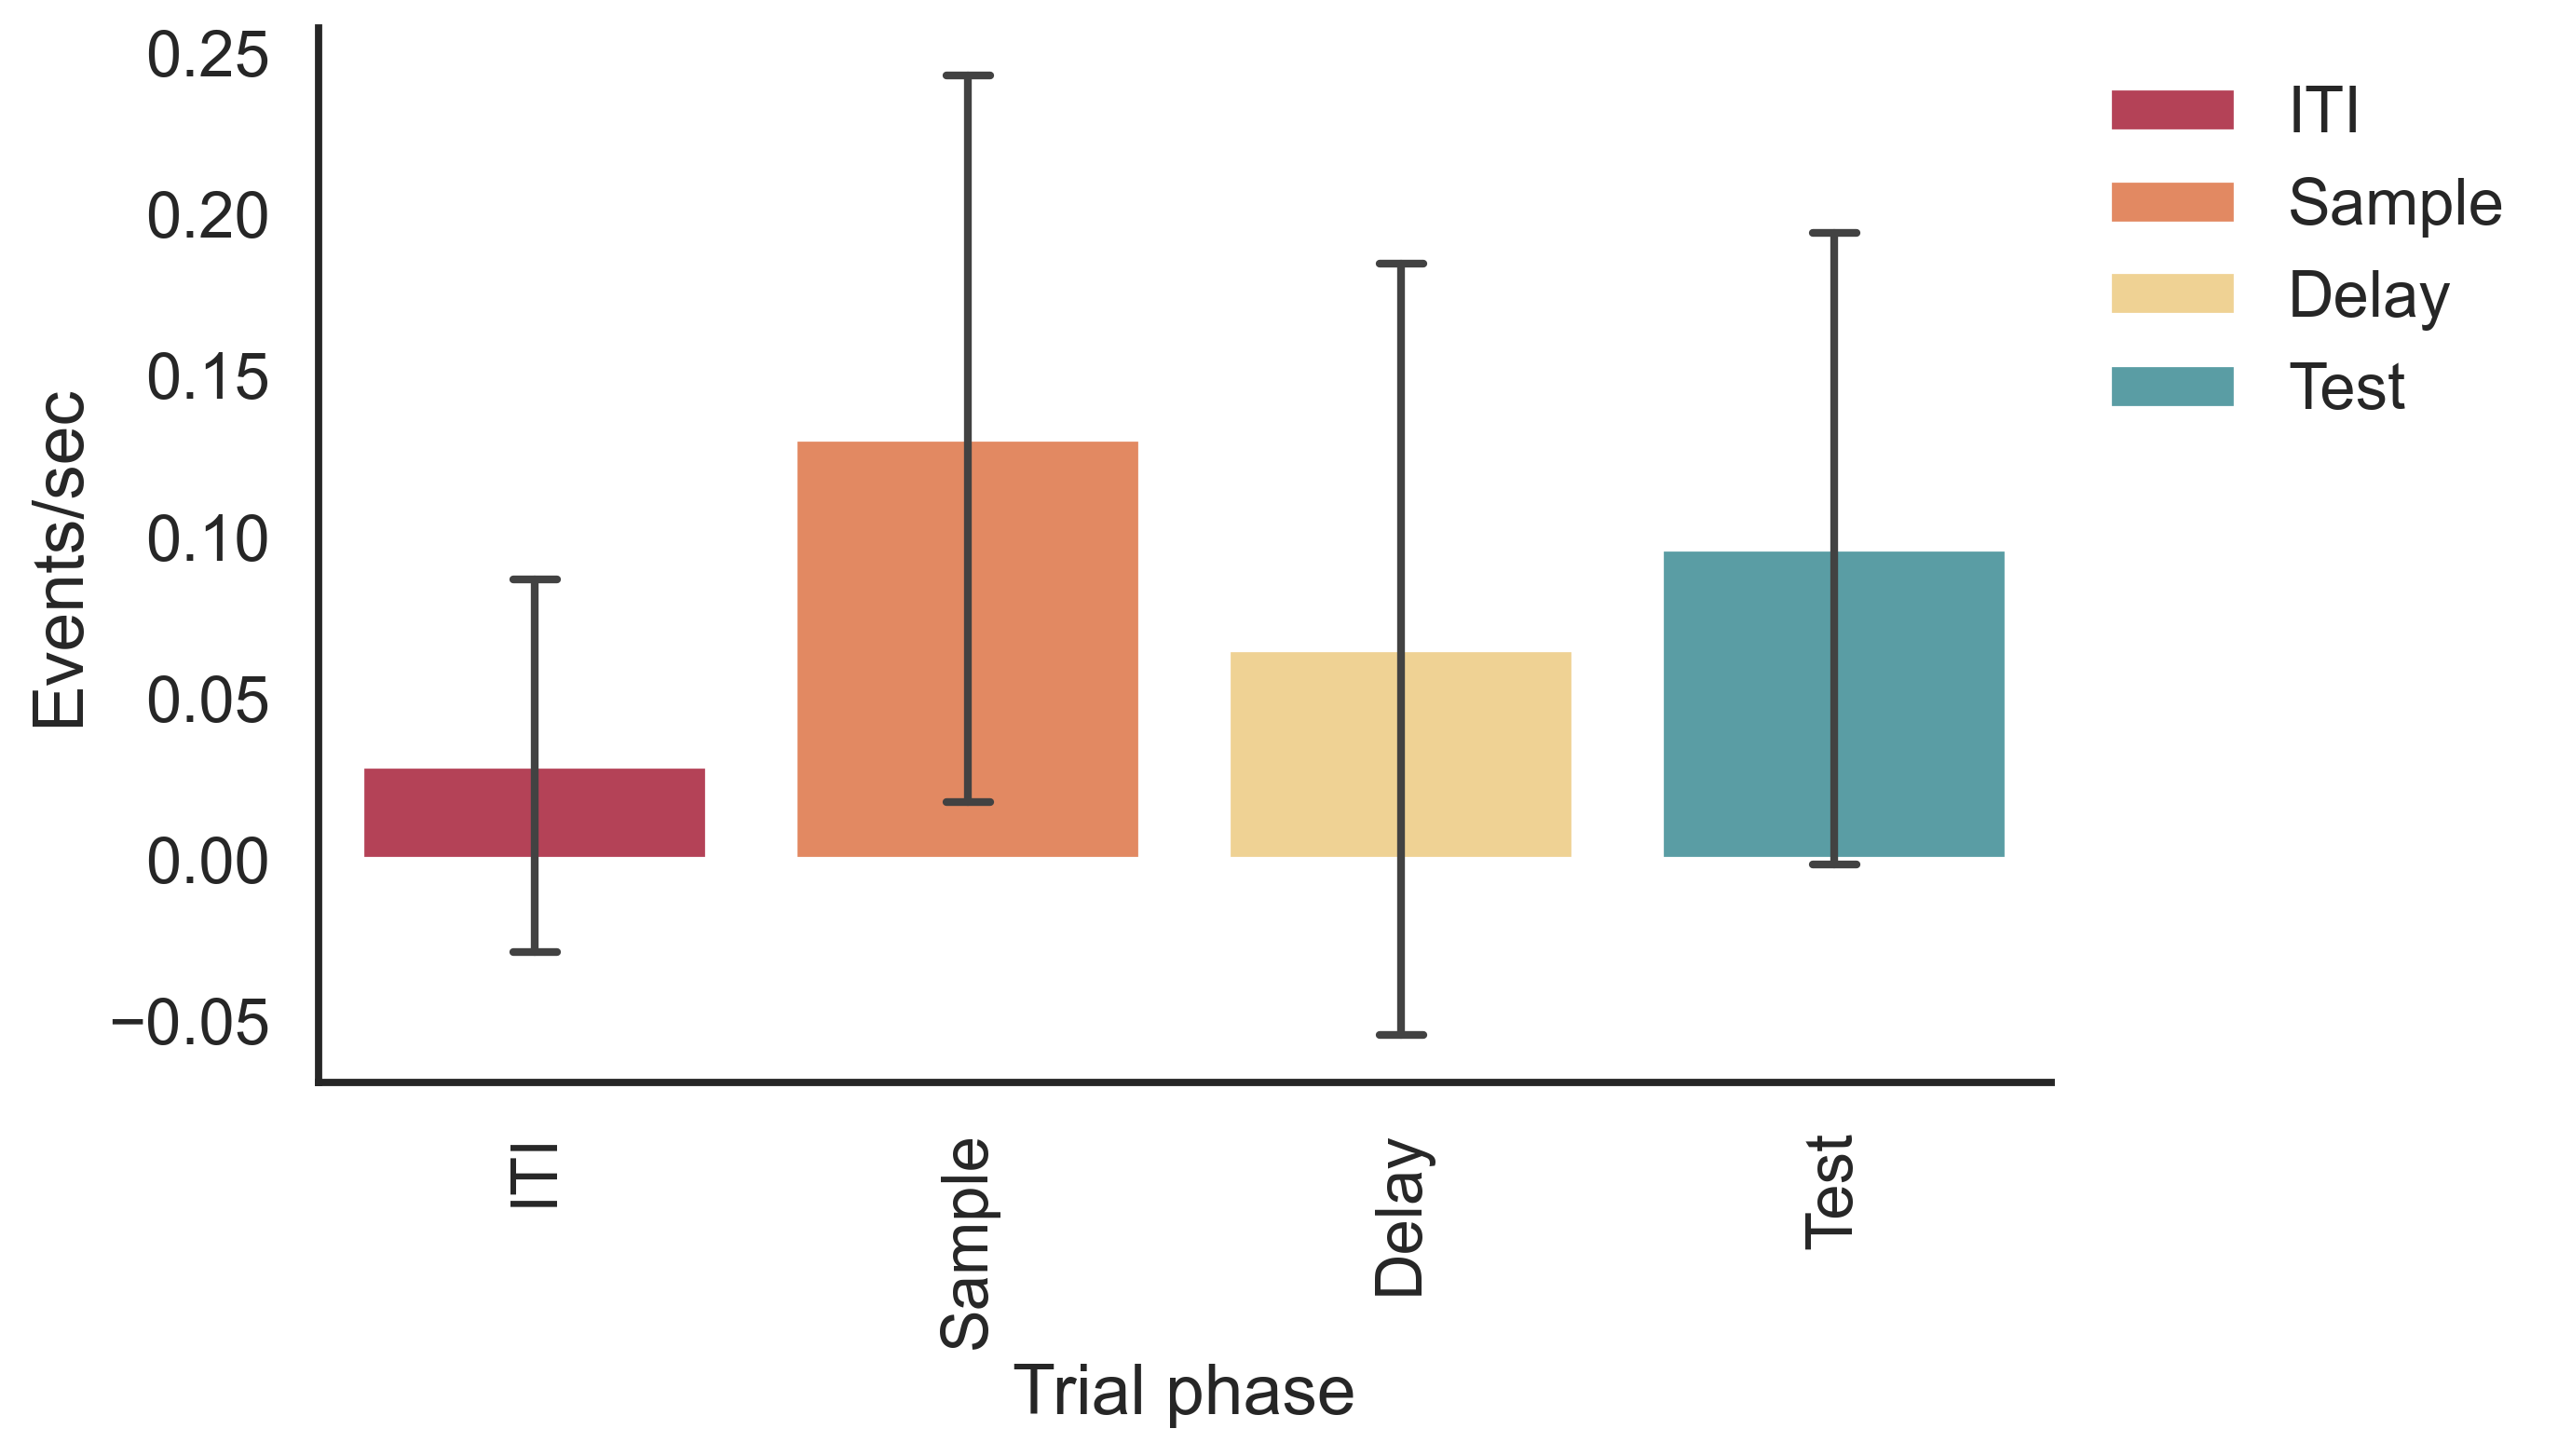

In [40]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(8,5), dpi=300)

g= sns.barplot(
    data=rate_by_phase,  x='phase', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, order=order,
    estimator=np.mean, ci='sd', dodge=False,
    errwidth=2, capsize=.1)

g.set_xlabel('Trial phase')
g.set_ylabel('Events/sec')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

### Event duration distribution by task phase

Are the duration of events modulated by task phase?

No handles with labels found to put in legend.


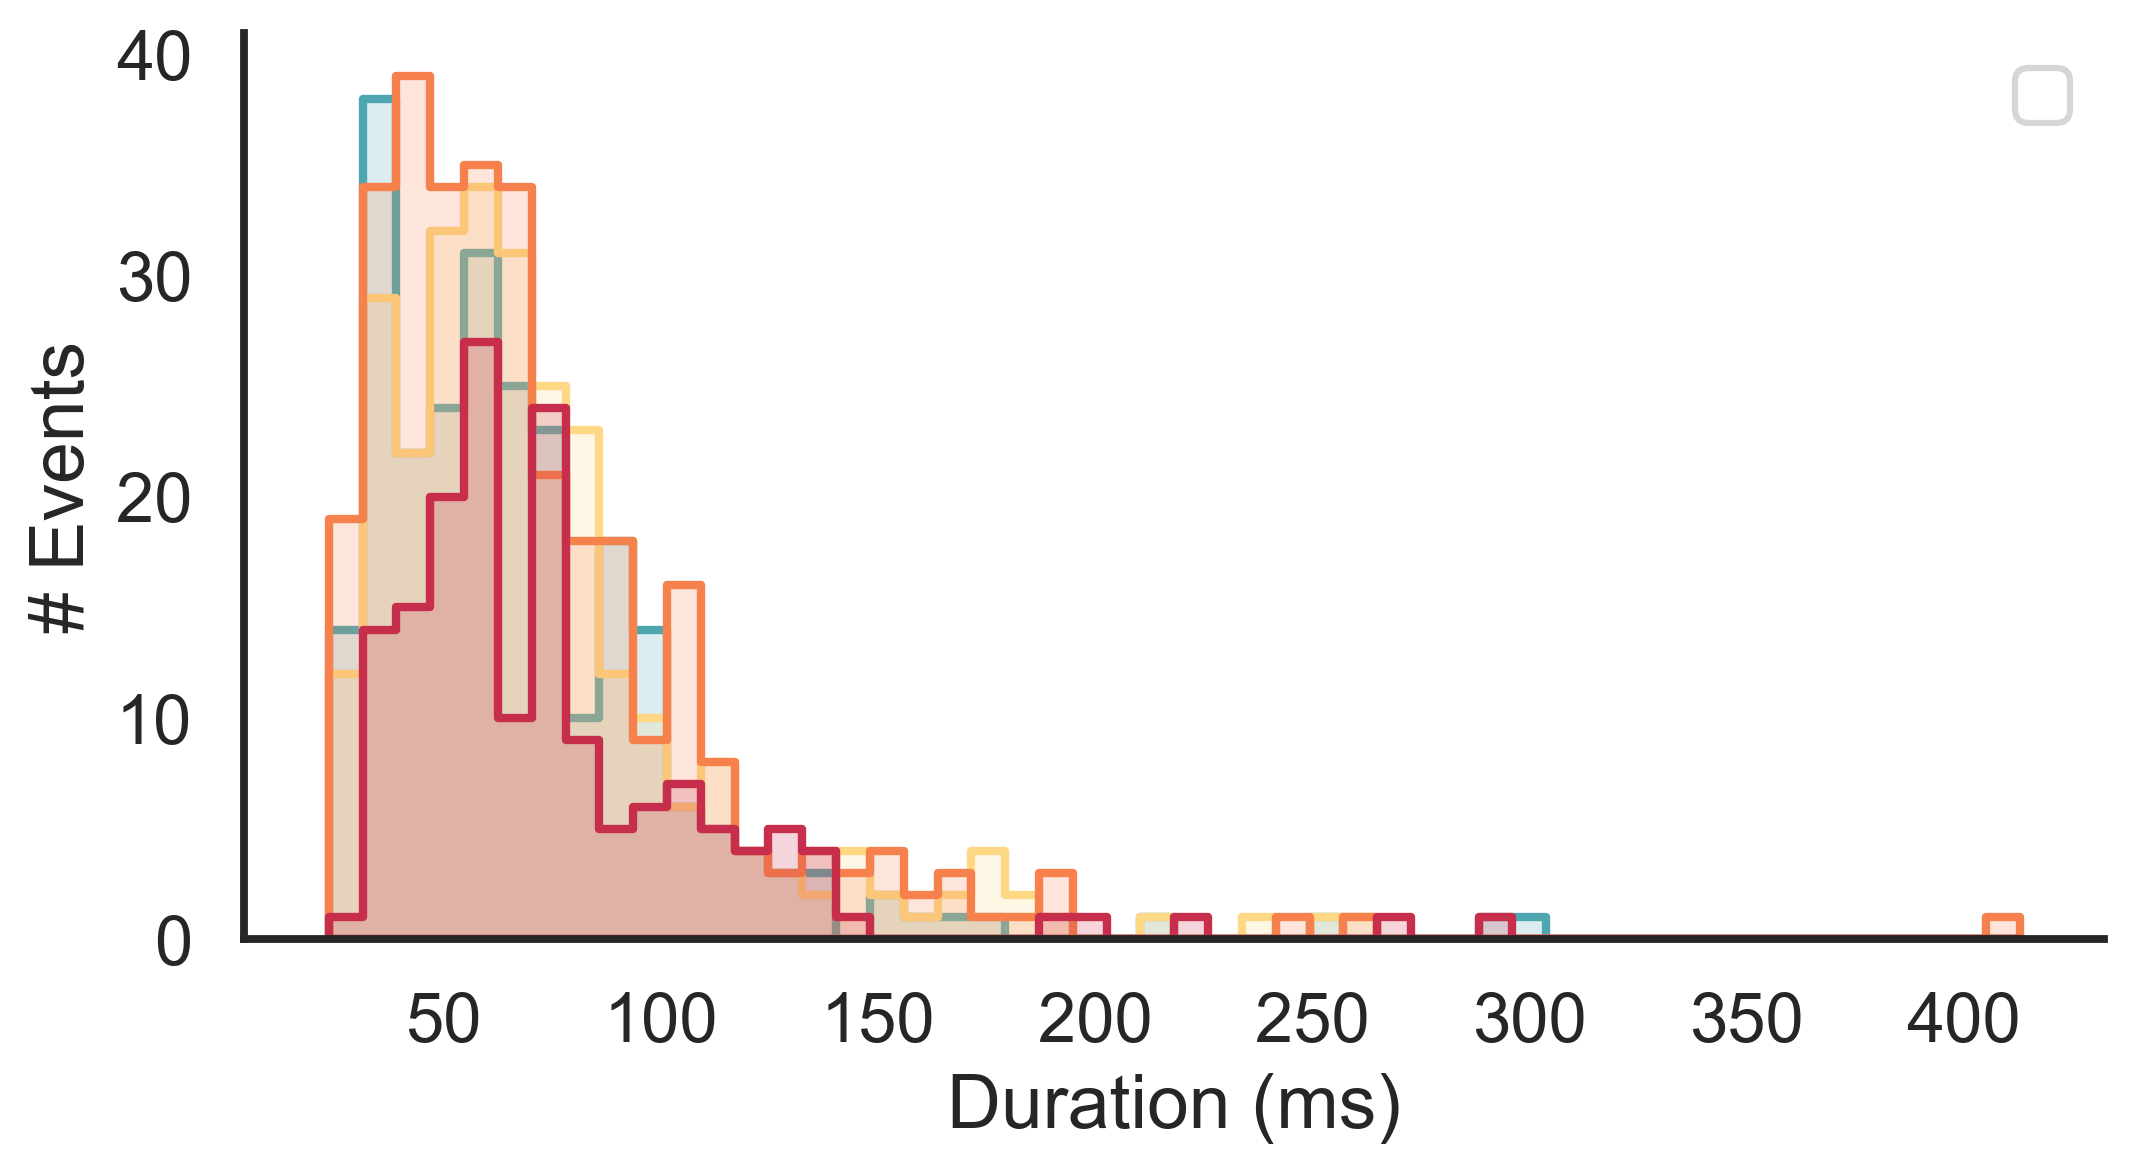

In [41]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(8,4), dpi=300)

sns.histplot(
    data=ripples,
    x='duration_ms', hue='phase',
    palette=phase_palette, linewidth=2, 
    hue_order=order, legend=True,
    element="step", fill=True, bins=50, alpha=.2
)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Duration (ms)')
plt.ylabel('# Events')
sns.despine()

No handles with labels found to put in legend.


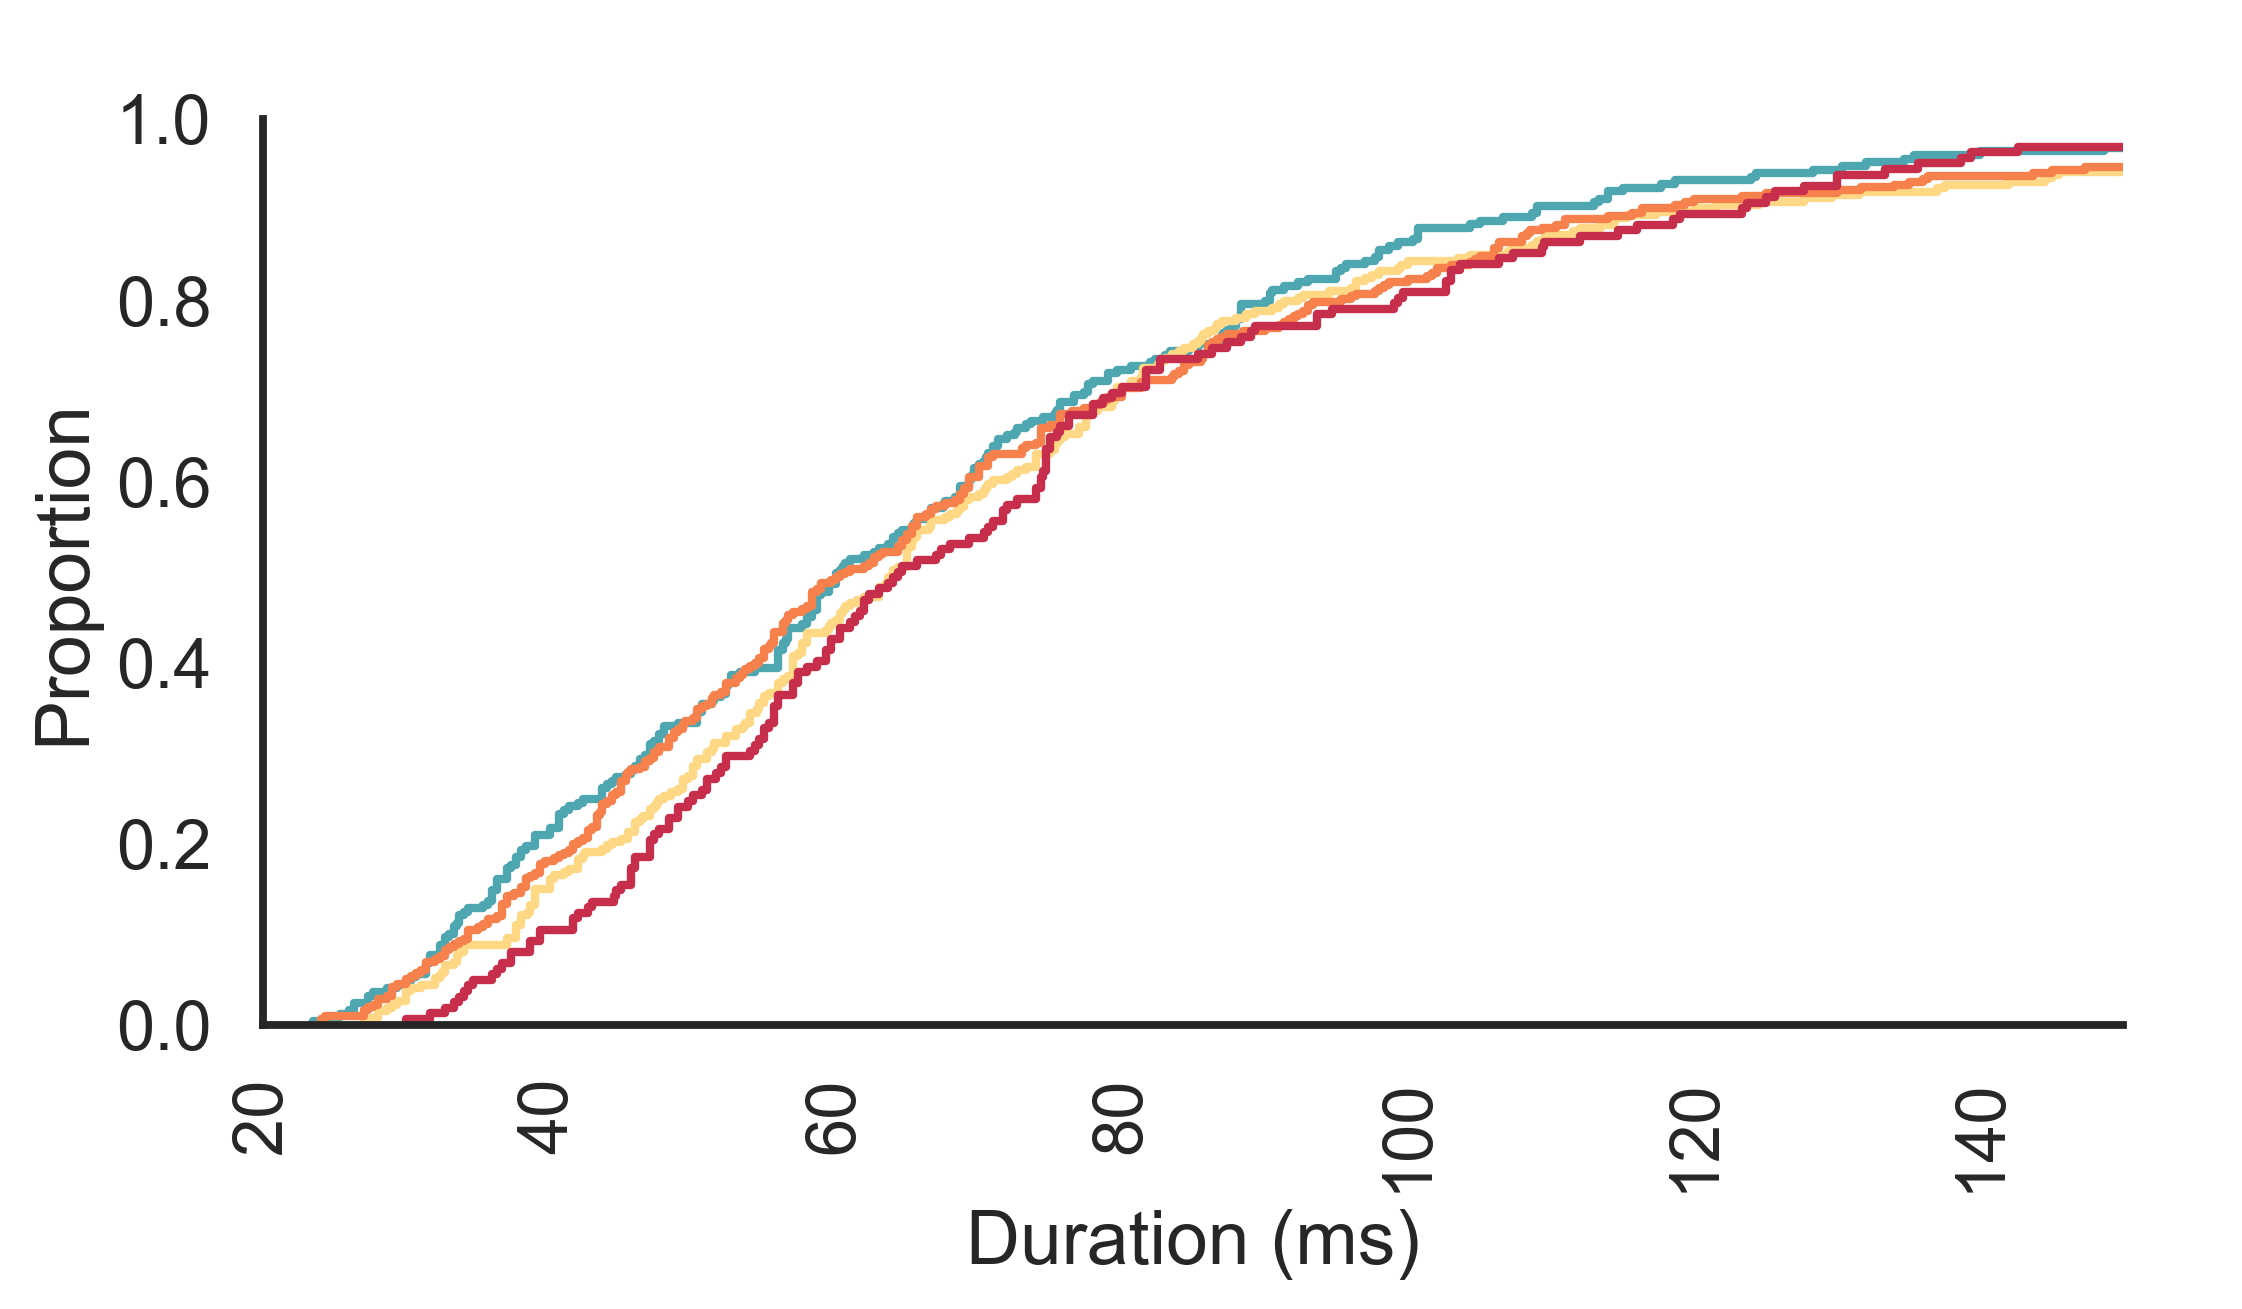

In [42]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(8,4), dpi=300)

sns.ecdfplot(
    data=ripples,
    x='duration_ms', hue='phase',
    palette=phase_palette, linewidth=2, 
    hue_order=order)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Duration (ms)')
plt.xlim([20,150])
plt.xticks(rotation=90)
sns.despine()

### Event rate by phase and trial outcome

Investigate duration distribution and rate of occurrence by task phase and outcome. 
Calculate the rate of occurrence by trial, phase and outcome, normalised by the time spent in trial (1 datapoint per trial)

In [43]:
# Ripple count (numerator)
ripple_count=ripples.groupby(['session_code', 'trial_nr','phase', 'outcome'])['start_time'].count().reset_index().rename(
    {'start_time':'ripples'}, axis=1)
# Calculate time spent in each task phase per dataset (denominator)
phase_durations = position.groupby(['session_code', 'trial_nr', 'phase', 'outcome'])['timestamp'].agg(['min', 'max'])
phase_durations['duration']=phase_durations['max']-phase_durations['min']

In [44]:
rate_by_phase_outcome = pd.merge(
    phase_durations, 
    ripple_count,
    how='left', 
    on=['session_code', 'trial_nr','phase', 'outcome']
).fillna(0)

In [45]:
rate_by_phase_outcome['rate']=rate_by_phase_outcome['ripples']/rate_by_phase_outcome['duration']

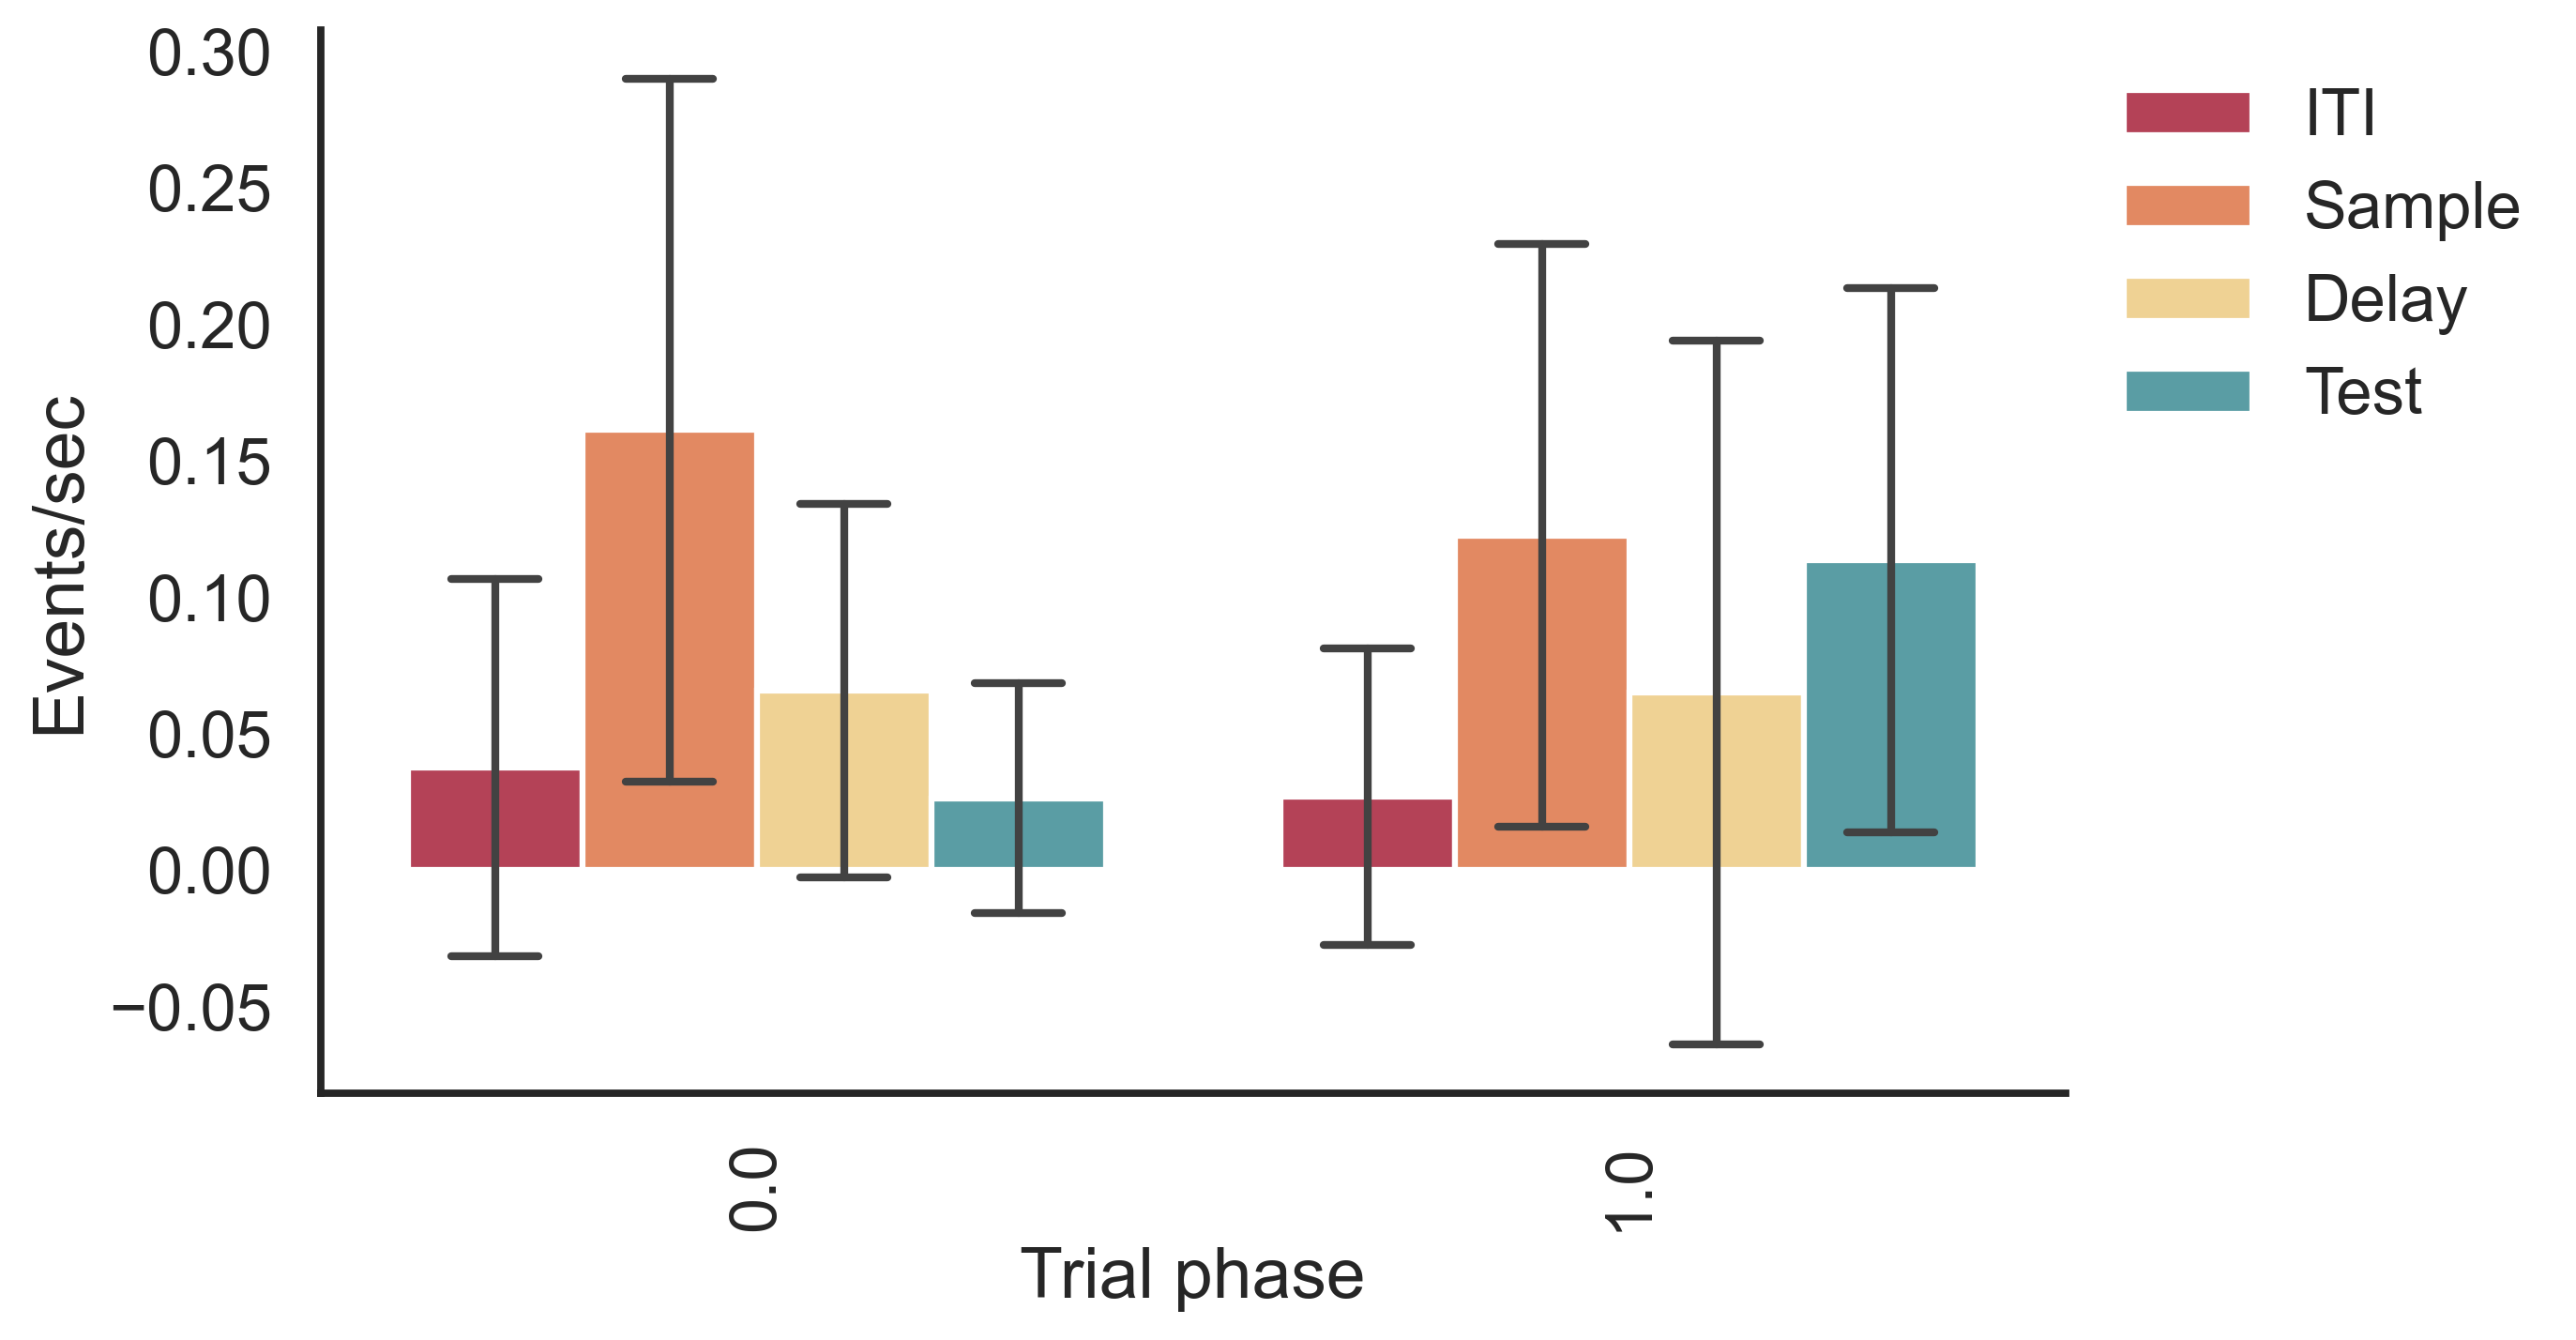

In [46]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(8,5), dpi=300)

g= sns.barplot(
    data=rate_by_phase_outcome,  x='outcome', y='rate', hue='phase',
    palette=phase_palette, hue_order=order,
    estimator=np.mean, ci='sd', dodge=True,
    errwidth=2, capsize=.1)

g.set_xlabel('Trial phase')
g.set_ylabel('Events/sec')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

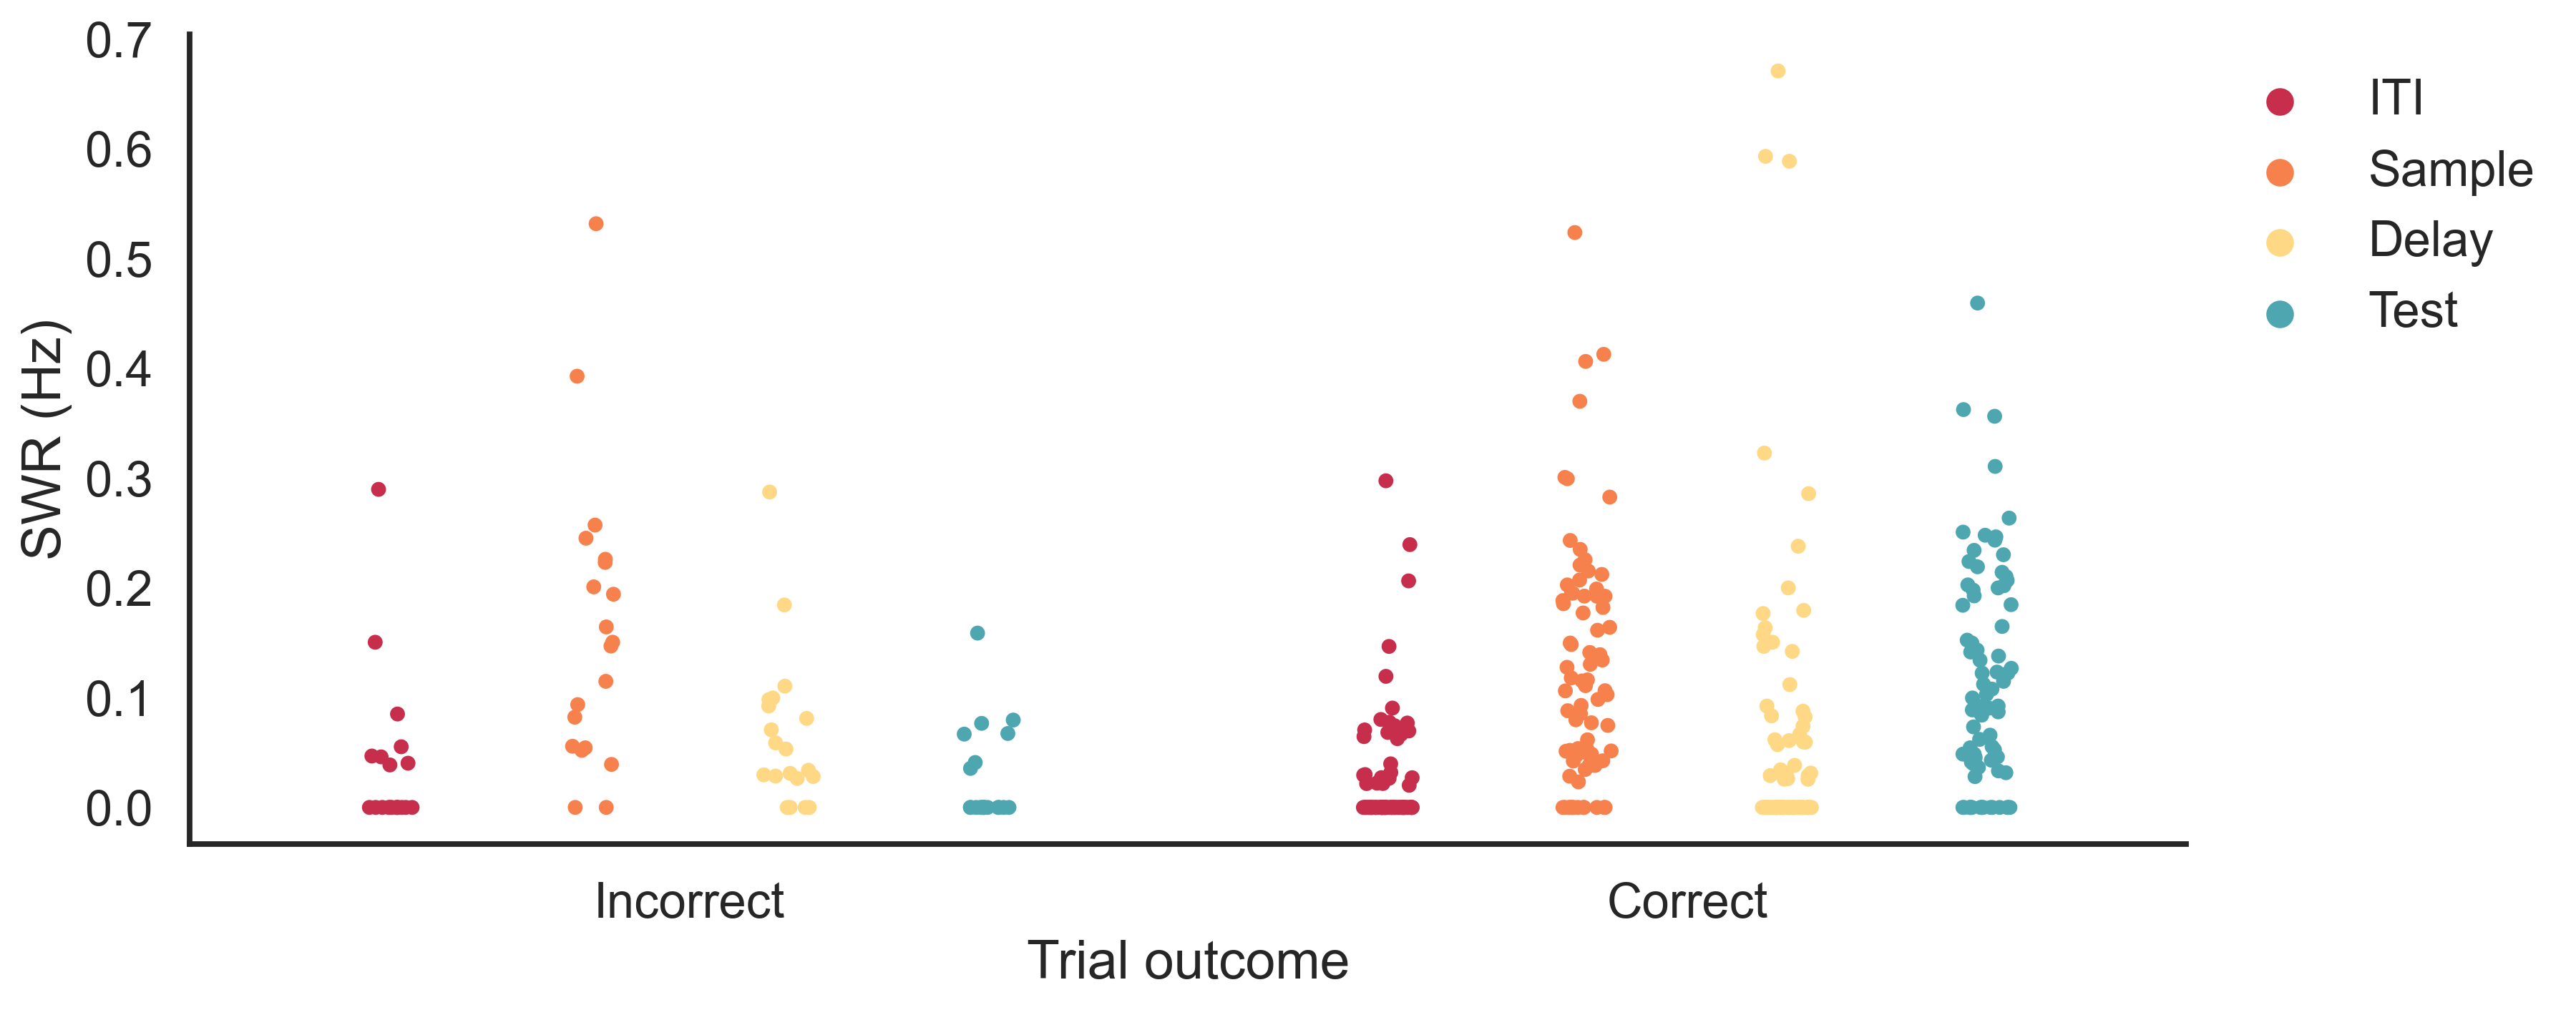

In [72]:
order = ['ITI', 'Sample', 'Delay', 'Test']
sns.set(style='white', context=plot_context)
plt.figure(figsize=(12,5), dpi=300)

g= sns.stripplot(
    data=rate_by_phase_outcome,  x='outcome', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, s=5, dodge=True)

g.set_xlabel('Trial outcome')
g.set_ylabel('SWR (Hz)')
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

### Are ripple durations modulated by trial outcome x phase?

<Figure size 2400x1200 with 0 Axes>

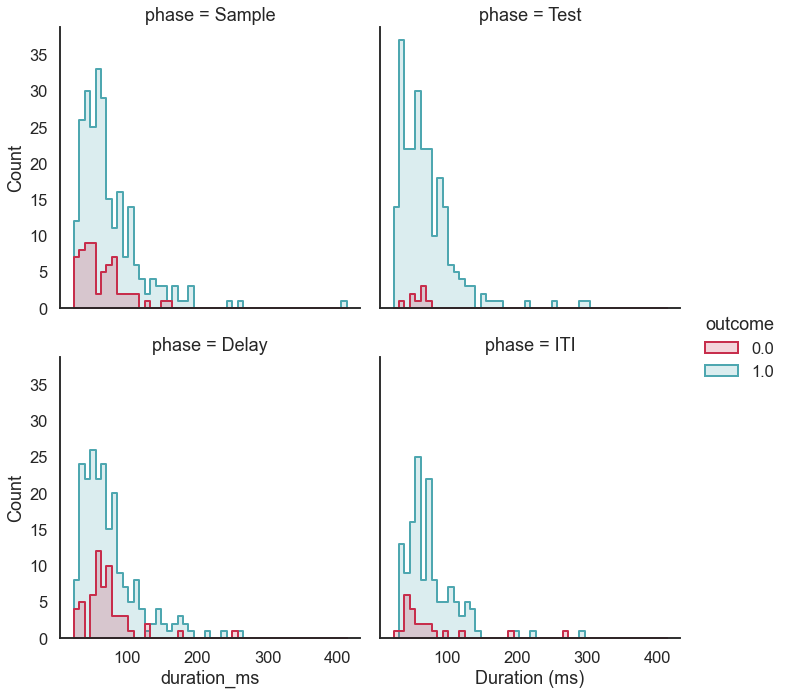

In [393]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(8,4), dpi=300)

sns.displot(
    kind='hist',
    data=ripples,
    col='phase', col_wrap=2,
    x='duration_ms', hue='outcome',
    palette=[phase_palette[0], phase_palette[3]], linewidth=2, 
    #hue_order=order, 
    legend=True,
    element="step", fill=True, bins=50, alpha=.2
)

#plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Duration (ms)')
#plt.ylabel('# Events')
sns.despine()

## Percentage of trials with ripple occurrence at the reward port 
- By trial outcome and task phase

In [48]:
rw1_rois = pd.read_csv(os.path.join(main_path, 'rw1_rois.csv'))
rw2_rois = pd.read_csv(os.path.join(main_path, 'rw2_rois.csv'))

In [91]:
# add column to ripple - if in reward port
def add_in_ports_info(row, rw1_rois, rw2_rois, colx, coly):
    '''
    Returns a boolean indicating if ripple row occurred close to reward ports
    '''
    
    session=row['session_code']
    session_rw1 = rw1_rois[rw1_rois['session']==session]
    session_rw2 = rw2_rois[rw2_rois['session']==session]
    x=row[colx]
    y=row[coly]
    
    if  ((session_rw1['x'].iloc[0]-20 <= x <=session_rw1['x'].iloc[0]+20) &\
        (session_rw1['y'].iloc[0]-30 <= y <= session_rw1['y'].iloc[0]+30)) |\
        ((session_rw2['x'].iloc[0]-20 <= x <=session_rw2['x'].iloc[0]+20) &\
         (session_rw2['y'].iloc[0]-30 <= y <= session_rw2['y'].iloc[0]+30)):   
        return 1
    else:
        return 0

In [50]:
ripples['at_reward']=ripples.apply(add_in_ports_info, 
                                   args=(rw1_rois, rw2_rois,'x_ripple', 'y_ripple',), 
                                   axis=1)

<ipython-input-50-72dbe5f9829a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ripples['at_reward']=ripples.apply(add_in_ports_info, args=(rw1_rois, rw2_rois,), axis=1)


C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


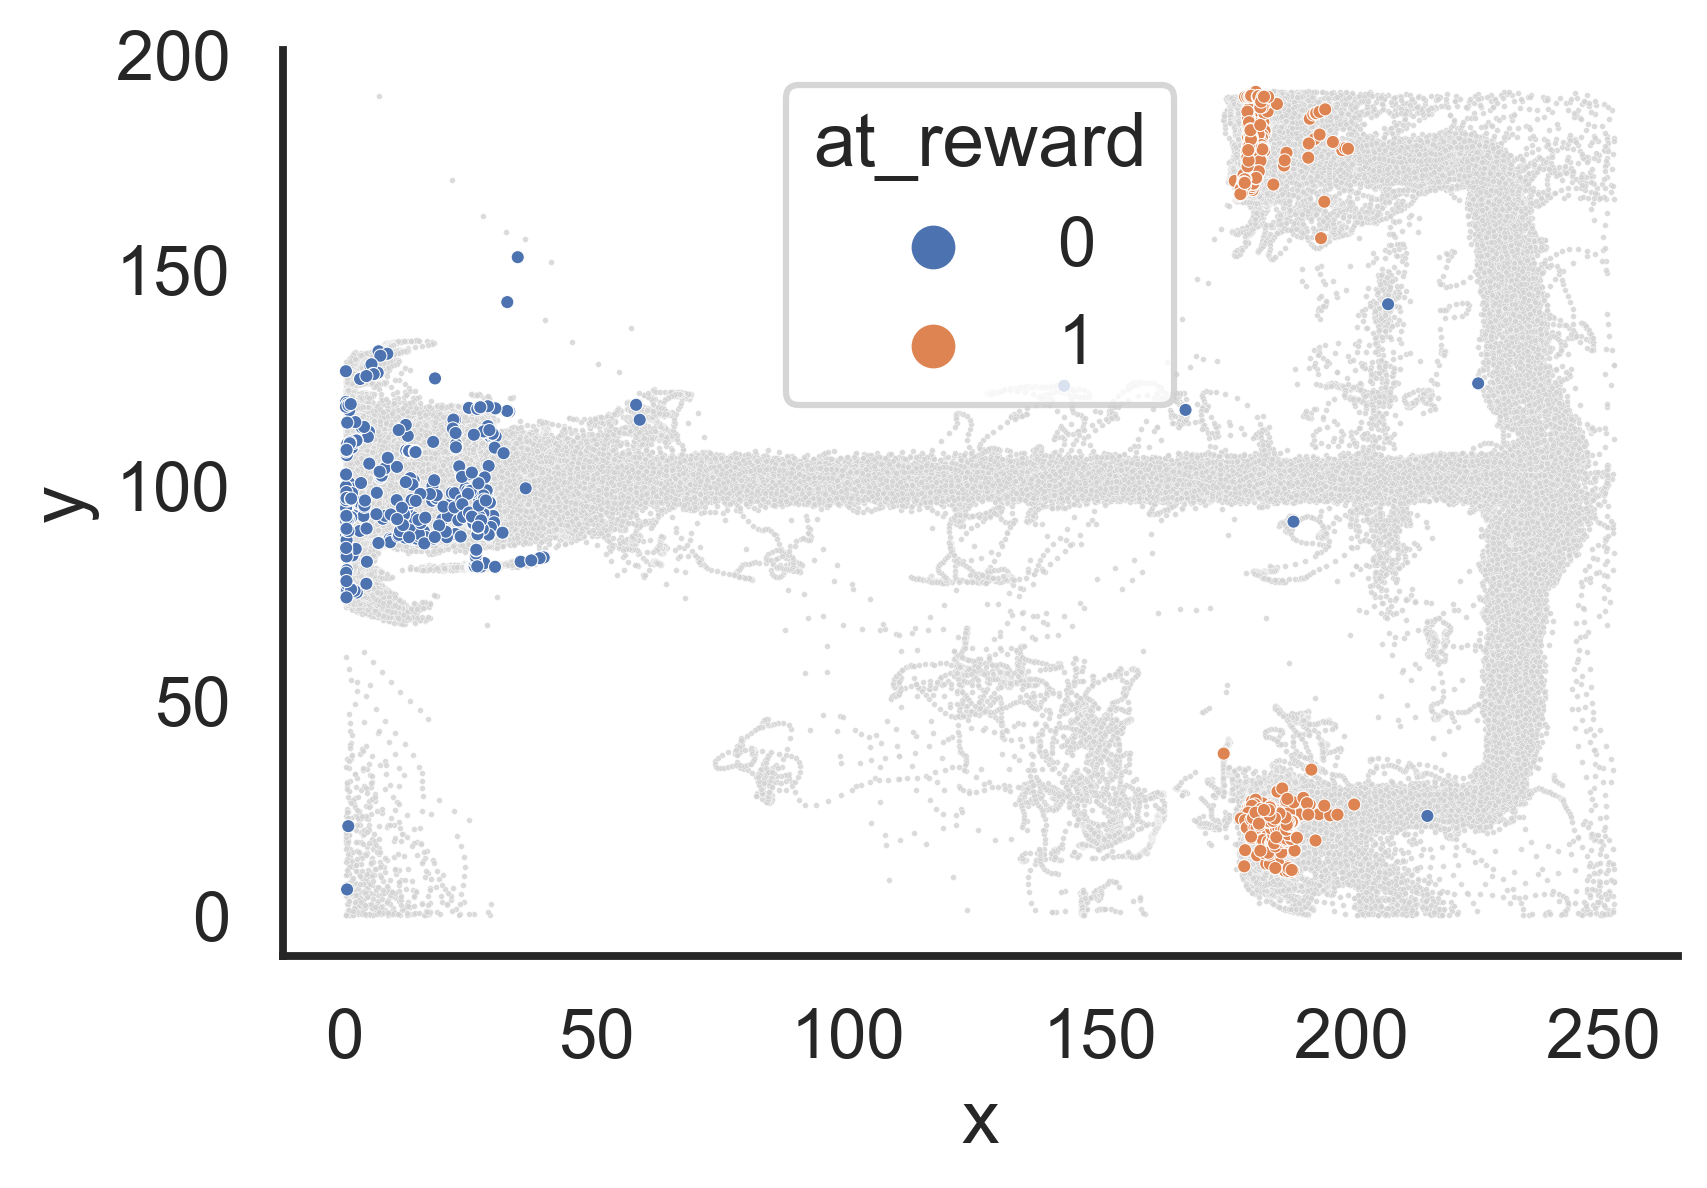

In [51]:
plt.figure(dpi=300)
g = sns.scatterplot(
    data = position,
    x='x', y='y',
    color='lightgray', s=2, alpha=.8
)
sns.scatterplot(
    data = ripples,
    x='x_ripple', y='y_ripple',hue='at_reward',
    s=10)

sns.despine()

In [54]:
# Label trials with ripples as having them at reward port during test 
reward_count=ripples.groupby(
    ['session_code', 'trial_nr', 'phase','outcome'])['at_reward'].sum().reset_index()
reward_count['has_rw_ripples']=np.where(reward_count.at_reward>0, 1, 0)

# Calculate all trial combinations
trial_combos=position[['session_code', 'trial_nr', 'phase',  'outcome']].groupby(
    ['session_code', 'trial_nr','phase','outcome']).size(
    ).reset_index(
    ).drop([0], axis=1)

trial_combos = trial_combos[trial_combos.phase.isin(['Sample', 'Test'])]

In [63]:
# Merge both
trial_rw_ripples = pd.merge(trial_combos,
        reward_count,
        how='left',
        on=['session_code', 'trial_nr', 'phase', 'outcome']).drop(['at_reward'], axis=1).fillna(0)

# Calculate percentage of trials with ripples at reward port during sample vs. test 
num=trial_rw_ripples.groupby(['phase', 'outcome'])['has_rw_ripples'].sum()
denom=trial_rw_ripples.groupby(['phase', 'outcome'])['has_rw_ripples'].count()

trials_rw_ripples_percent=(num/denom).reset_index().rename({'has_rw_ripples': 'percentage'}, axis=1)
trials_rw_ripples_percent['percentage']=trials_rw_ripples_percent['percentage']*100

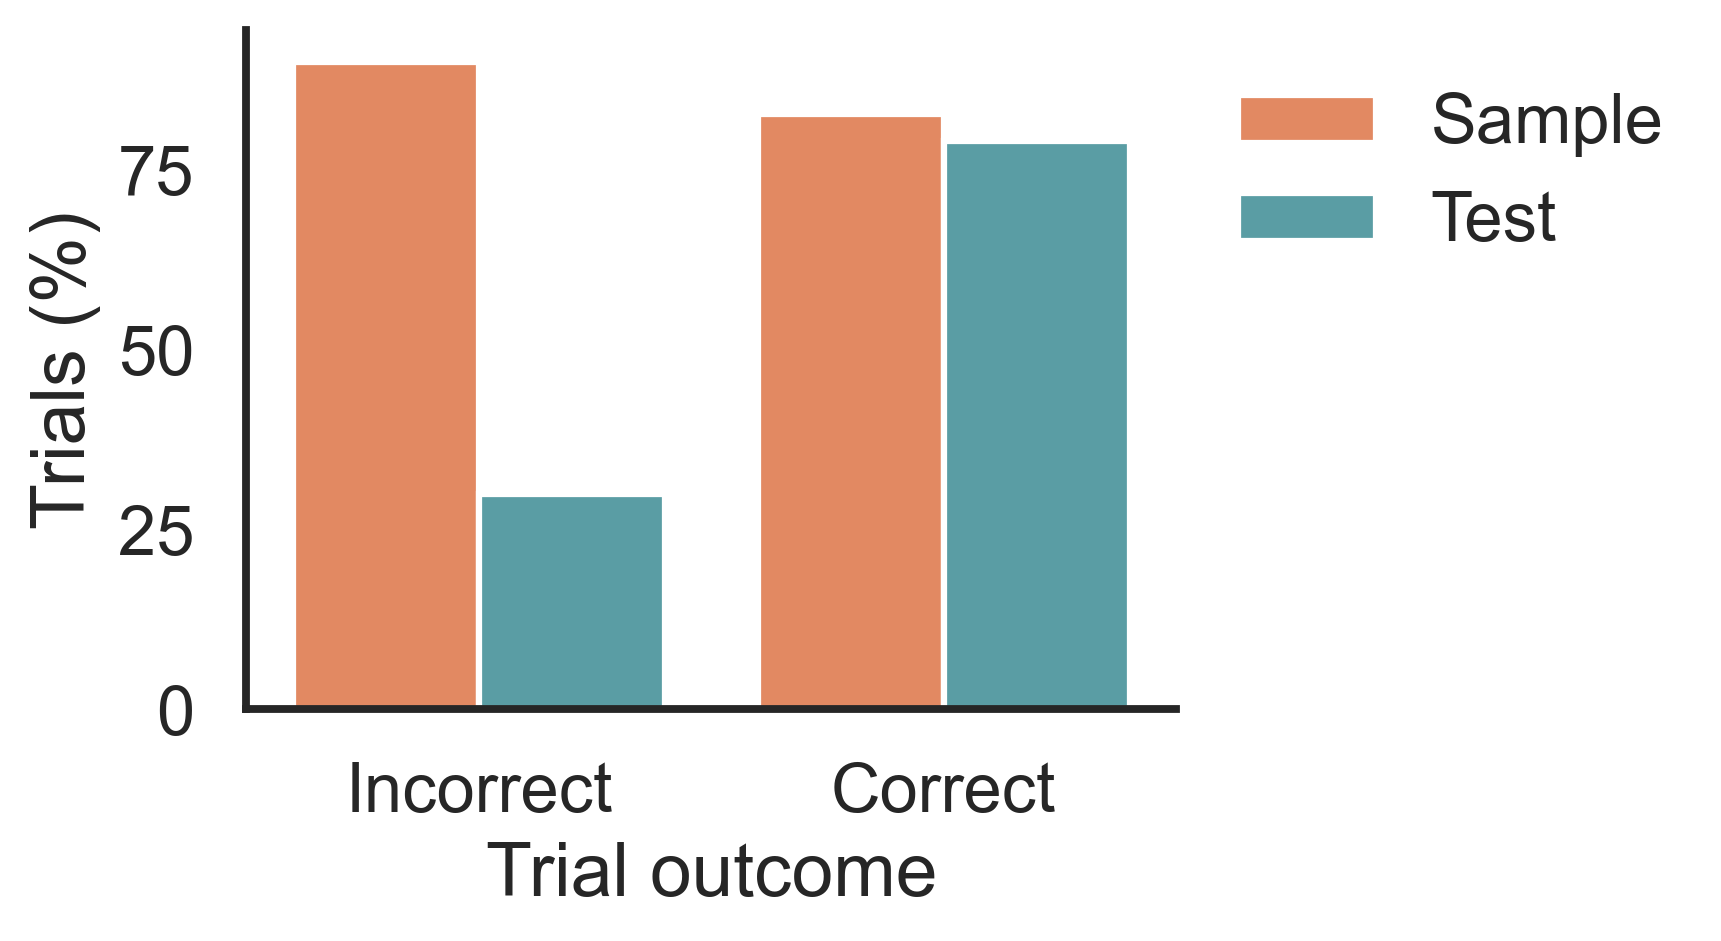

In [79]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(4,3), dpi=300)
g=sns.barplot(
    data=trials_rw_ripples_percent,  x='outcome', y='percentage', hue='phase',
    palette=[phase_palette[1], phase_palette[3]])


g.set_xlabel('Trial outcome')
g.set_ylabel('Trials (%)')
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

### SWR rate at reward ports 

In [97]:
rw_ripples=ripples[ripples.at_reward==1]
position_trj = position[position.phase.isin(['Sample', 'Test'])]

In [106]:
data = pd.merge(
    position_trj,
    rw1_rois,
    how='left',
    on=['session']
).rename(
    {'x_x':'x',
    'y_x':'y',
    'x_y':'rw1_x',
    'y_y':'rw1_y'}, axis=1
).merge(
    rw2_rois,
    how='left',
    on=['session']
).rename(
    {'x_x':'x',
    'y_x':'y',
    'x_y':'rw2_x',
    'y_y':'rw2_y'}, axis=1
).drop(
    ['width_x', 'width_y', 'height_x', 'height_y'], 
    axis=1
)


rw_data = data[
    ((data.x.between(data.rw1_x-20, data.rw1_x+20)) & (data.y.between(data.rw1_y-30, data.rw1_y+30))) | 
    ((data.x.between(data.rw2_x-20, data.rw2_x+20)) & (data.y.between(data.rw2_y-30, data.rw2_y+30)))
]

In [160]:
time_at_rw = rw_data.groupby(
    ['session', 'trial_nr', 'run_type', 'outcome']
).agg(
    {'timestamp':['min', 'max']}
).reset_index()

# Re-arrange dataframe columns from multi-index
time_at_rw.columns=list(map(''.join, time_at_rw.columns.values))
# Calculate time spent at reward port
time_at_rw['deltat']=time_at_rw.timestampmax-time_at_rw.timestampmin

#Calculate ripple count per trial and run
rw_ripple_count=rw_ripples.groupby(['session_code','trial_nr', 'run_type','outcome']).size().reset_index().rename(
    {'session_code':'session', 0:'n_ripples'}, axis=1)

In [162]:
# Calculate rate
rw_rate= time_at_rw.merge(
    rw_ripple_count, 
    how='left',
    on=['session', 'trial_nr', 'run_type', 'outcome']).fillna(0)

rw_rate['rate']=rw_rate['n_ripples']/rw_rate['deltat']

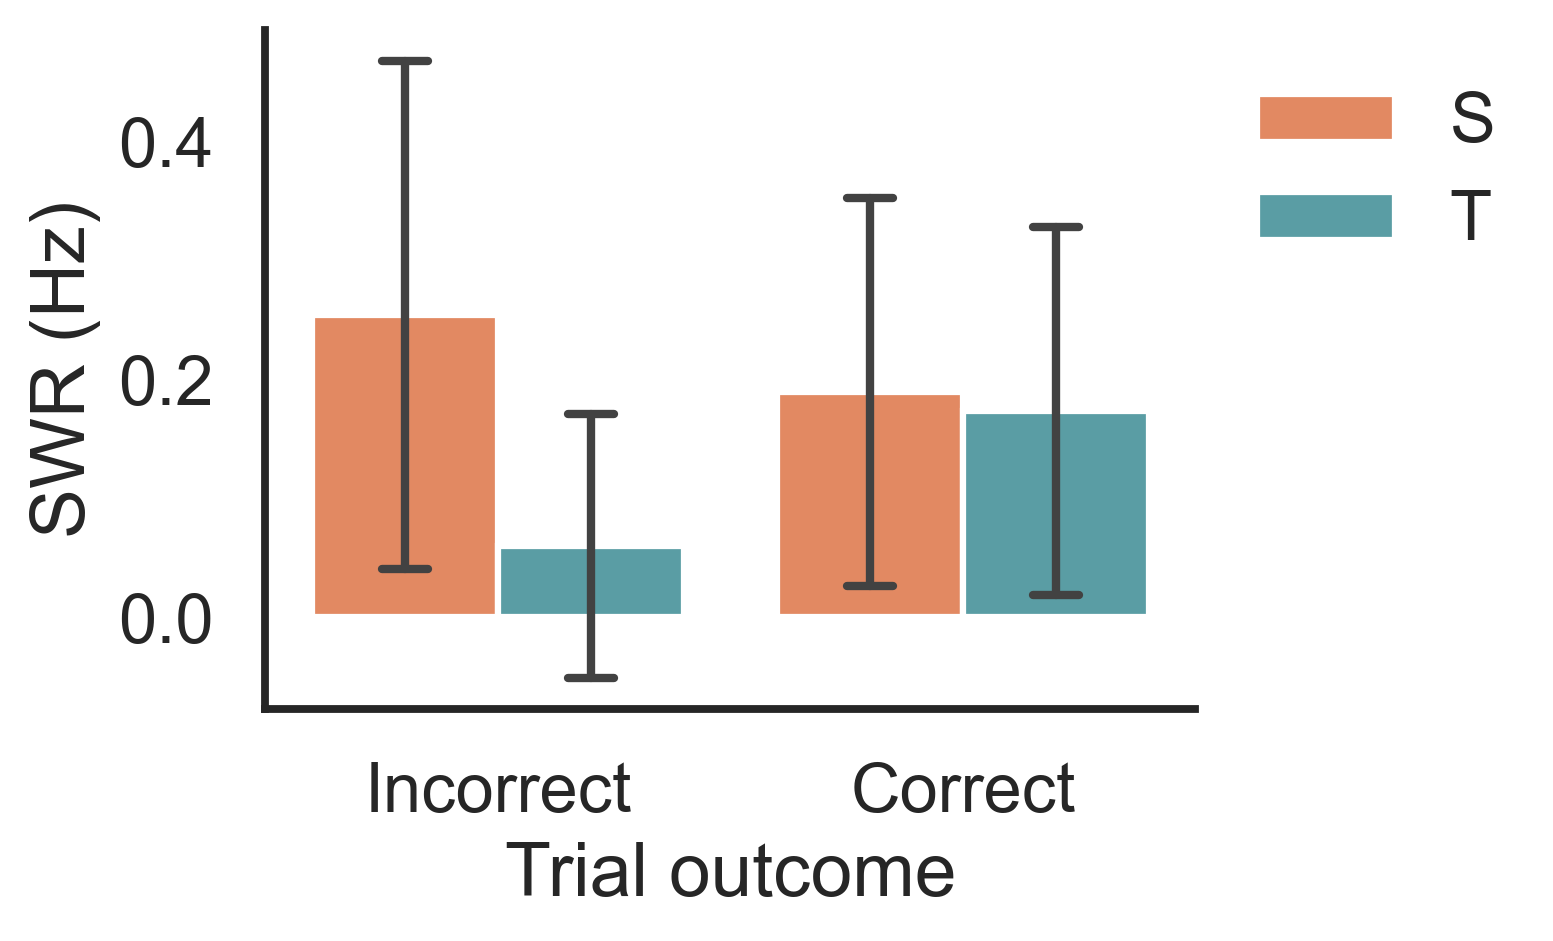

In [172]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(4,3))
g=sns.barplot(
    data=rw_rate,
    x='outcome',
    y='rate',
    hue='run_type',
    estimator=np.mean,
    ci='sd',
    palette=[phase_palette[1], phase_palette[3]],
    errwidth=2, capsize=.1)

g.set_xlabel('Trial outcome')
g.set_ylabel('SWR (Hz)')
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1,1), frameon=False)

sns.despine()